In [1]:
# To avoid: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. 
# You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns 
import imageio
import pandas as pd 
from IPython.display import Image 

from params_sys import *
from utils import *
from utils_sys import *
from utils_plot import *

from mobility_model import *        # Load the Gauss-Markov mobility model 
from channel_model import *         # Load the channel model (LoS+NLoS)
from traffic_model import *         # Load the traffic model 
from uav_controller import *        # Load the UAV movement controller class 

rng = np.random.default_rng()

%matplotlib inline

Requesting rate: 1.0 		# Rate (on average) at which users sending a download request
Arrival traffic: 2.0 Mbps 	# Average traffic load (of all services) if a user sending a request


Coverage area (m): 	500 x 500
Grid size (m): 		20 x 20
Heat map image: 	25 x 25


Normalization coefficients: 
user counter norm (1 grid): 	3.2 
queue_len_norm: 	40 Mb 
ch_capacity_norm: 	10 Mb


Folder for simulation outputs: c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10

Initial location of UAVs:
 [[-250  250]
 [-250 -250]
 [ 250 -250]
 [ 250  250]]
tensorflow version: 2.10.1
keras version: 2.10.0


# Simulation Setup

In [3]:
folder_path = os.path.join(os.getcwd(), 'dev', 'input')

### Gen User Movement (if not exist)

In [4]:
""" User movement: Gauss-Markov mobility model """
fpath = os.path.join(folder_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, br={boundary}.xlsx")
# assert os.path.exists(fpath)==False, f"Data existed! in {fpath}"

if os.path.exists(fpath)==False: 
    # Tracking positions of all users over time  
    xaxis_all = np.zeros(shape=(n_users, n_slots))          # x-axis 
    yaxis_all = np.zeros(shape=(n_users, n_slots))          # y-axis 

    # Gen user movements using the Gauss-Markov model 
    for id in range(n_users):
        x0 = rng.choice(initial_distance_range_x)
        y0 = rng.choice(initial_distance_range_y)
        
        xaxis_all[id], yaxis_all[id] = generate_mobility_GM(x0=x0, y0=y0, boundary=boundary, 
                                            n_slots=n_slots, slot_len=slot_len, 
                                            upper_left=upper_left, lower_right=lower_right,
                                            speed_avg=speed_user_avg)
            
    # The centroid of all users over time 
    x_centroid = np.mean(xaxis_all, axis=0)
    y_centroid = np.mean(yaxis_all, axis=0)

    # Export to a xlsx file 
    to_excel(xaxis_all, os.path.join(folder_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, br={boundary}.xlsx"))
    to_excel(yaxis_all, os.path.join(folder_path, f"ylocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, br={boundary}.xlsx"))
    print(f'Exported data to {folder_path}')


### Gen User Traffic (if not exist)
- ON-OFF Model
- Reference on the Exponential Moving Average (EMA): [here]()

In [5]:
from copy import deepcopy

fpath = os.path.join(folder_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx")
# assert os.path.exists(fpath)==False, f"Data existed! in {fpath}"

if os.path.exists(fpath)==False:
    arrival_traffic_Mb = np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)       # shape=(n_users,n_slots)
    ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)          # EMA of the arrival rate (Mbps)
    traffic_state = np.full(shape=(n_users, n_slots), fill_value=0, dtype=bool)
    traffic_type = np.full(shape=(n_users,n_slots), fill_value=-1, dtype=int)

    for uid in range(n_users): 
        traffic_state[uid,:], arrival_traffic_Mb[uid,:], traffic_type[uid,:] = \
            generate_traffic_ON_OFF(n_slots=n_slots, 
                                    ON_duration_mean_tslot = ON_duration_mean_tslot,
                                    OFF_duration_mean_tslot = OFF_duration_mean_tslot,
                                    data_arrival_mean_Mb = ON_data_arrival_mean_Mb)

    ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
    for t in range(1,n_slots): 
        ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]
        
    lambd_Mb_alluser = np.mean(arrival_traffic_Mb, axis=1)        # shape=(n_users)
    
    # Export to a xlsx file 
    to_excel(arrival_traffic_Mb, os.path.join(folder_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
    to_excel(traffic_state, os.path.join(folder_path,f"traffic state, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
    to_excel(traffic_type, os.path.join(folder_path,f"traffic type, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
    print(f'Exported data to {folder_path}')


### Load user data

In [6]:
import pandas as pd 
from copy import deepcopy

def from_exel(fname):
    x = pd.read_excel(fname, index_col=0).to_numpy()
    y = np.transpose(x)
    return y
    
folder_path = os.path.join(os.getcwd(), 'dev', 'input')

### Load user location data 
xaxis_all = from_exel(os.path.join(folder_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, br={boundary}.xlsx"))
yaxis_all = from_exel(os.path.join(folder_path, f"ylocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, br={boundary}.xlsx"))
x_centroid = np.mean(xaxis_all, axis=0)
y_centroid = np.mean(yaxis_all, axis=0)

### Load user traffic data 
arrival_traffic_Mb = from_exel(os.path.join(folder_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
traffic_state = from_exel(os.path.join(folder_path,f"traffic state, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
traffic_type = from_exel(os.path.join(folder_path,f"traffic type, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)          # EMA of the arrival rate (Mbps)
ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
for t in range(1,n_slots): 
    ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]
lambd_Mb_alluser = np.mean(arrival_traffic_Mb, axis=1)        # shape=(n_users)

print('Loaded user data from excel files')

Loaded user data from excel files


In [7]:
print('Mean Traffic of one user (expected): \t{x:.2f} Mb/slot'.format(x=np.mean(ON_data_arrival_mean_Mb)*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)) )
print('Mean Traffic of one user (generated): \t{x:.2f} Mb/slot'.format(x=np.mean(arrival_traffic_Mb)) )
print('Arrival Rate in ON-state (generated): \t{x:.2f} Mb/slot'.format(x=np.sum(arrival_traffic_Mb)/np.sum(traffic_state)))

Mean Traffic of one user (expected): 	2.00 Mb/slot
Mean Traffic of one user (generated): 	1.83 Mb/slot
Arrival Rate in ON-state (generated): 	1.83 Mb/slot


### Visualize user data

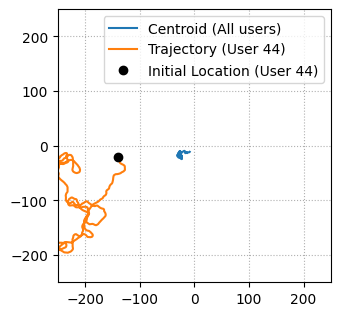

In [8]:
# Plotting 
id = np.random.choice(n_users)
fig, ax = plt.subplots(figsize=(3.5, 3.5))
plt.plot(x_centroid, y_centroid, label='Centroid (All users)')
plt.plot(xaxis_all[id], yaxis_all[id], label=f'Trajectory (User {id})')
plt.plot(xaxis_all[id][0], yaxis_all[id][0], 'ok', label=f'Initial Location (User {id})')
ax.set(xlim=(-boundary, boundary), ylim=(-boundary,boundary), aspect='equal')  
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

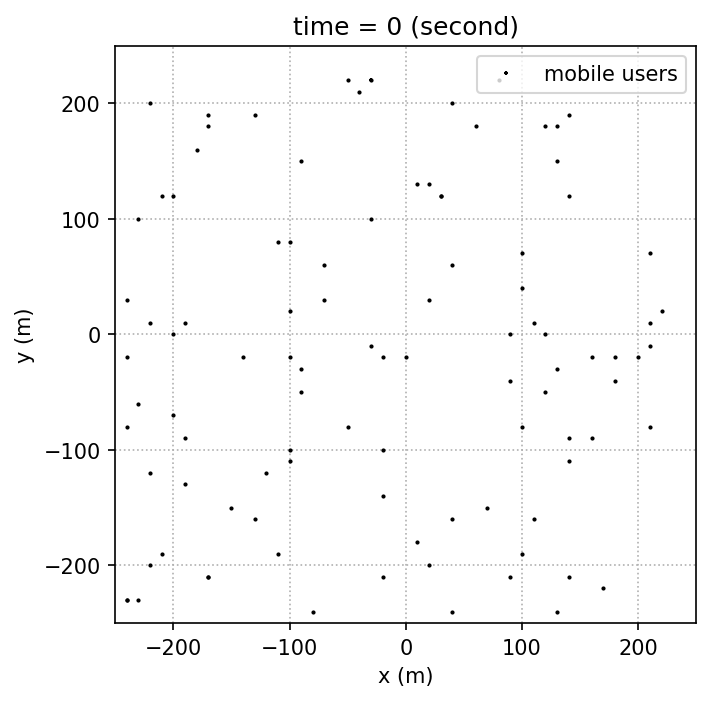

In [9]:
''' Animation of user locations '''
gif_path = gen_animation_user_locations(
    xaxis_all=xaxis_all, yaxis_all=yaxis_all, t_max = 100, t_step = 5, folder_name = 'dev/png2gif'
)
Image(filename=gif_path, width=350)


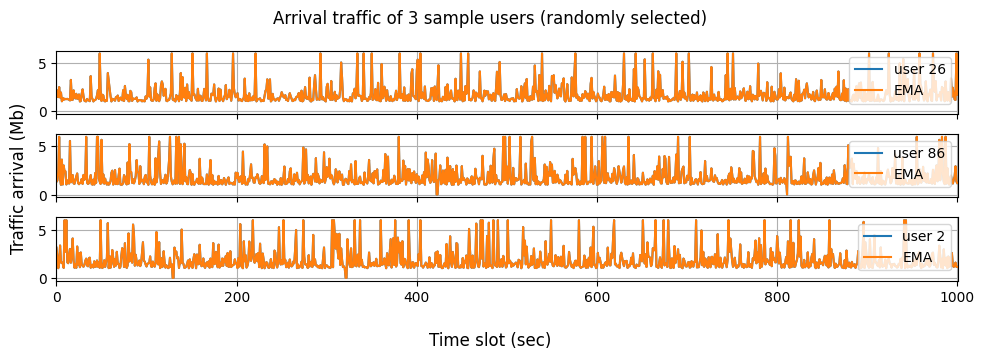

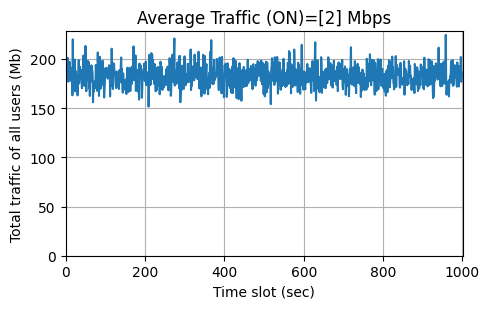

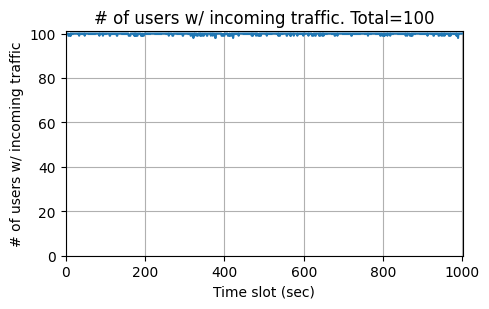

In [10]:
'''Arrival traffic of some sample users''' 
n_samples = 3
sample_ids = np.random.choice(n_users, size=(n_samples), replace=False) # randomly select some users for plotting 
fig, axes = plt.subplots(n_samples,1, figsize=(10, 3.5), sharex=True, sharey=True)
for i, axis in enumerate(axes):
    axis.plot(arrival_traffic_Mb[sample_ids[i]], label=f'user {sample_ids[i]}')
    axis.plot(ema_traffic_Mb[sample_ids[i]], label='EMA')
    axis.grid(True)
    axis.legend(loc='upper right')
    axis.set(xlim=[0, n_slots])    
fig.suptitle(f"Arrival traffic of {n_samples} sample users (randomly selected)")
fig.supxlabel('Time slot (sec)')
fig.supylabel('Traffic arrival (Mb)')
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path,"incoming_traffic_of_sample_users_over_time.png"), bbox_inches='tight')
plt.show()


"""Total incoming traffic of all users """
traffic_sum_Mb = np.sum(arrival_traffic_Mb, axis=0)
fig, ax = plt.subplots(figsize=(5,3.2)) 
plt.plot(traffic_sum_Mb)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='Total traffic of all users (Mb)', 
       title=f'Average Traffic (ON)={ON_data_arrival_mean_Mb} Mbps',
       xlim=[0, n_slots])
plt.ylim(bottom=0)
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path,"traffic-total-all-users.png"), bbox_inches='tight')
plt.show()


'''Number of users with incoming traffic''' 
traffic_state_sum = np.sum(traffic_state, axis=0)
fig, ax = plt.subplots(figsize=(5,3.2)) 
plt.plot(traffic_state_sum)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='# of users w/ incoming traffic', 
       title=f'# of users w/ incoming traffic. Total={n_users}',
       xlim=[0, n_slots], ylim=[0,n_users+1])
plt.axhline(y=n_users*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot), linestyle='--')
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path,"traffic-n_actives.png"), bbox_inches='tight')
plt.show()


### Test Channel Model

bw allocation (alpha) =  0.010
bw per user =  0.3 MHz


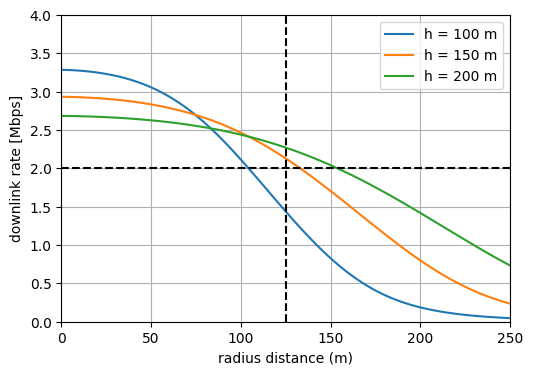

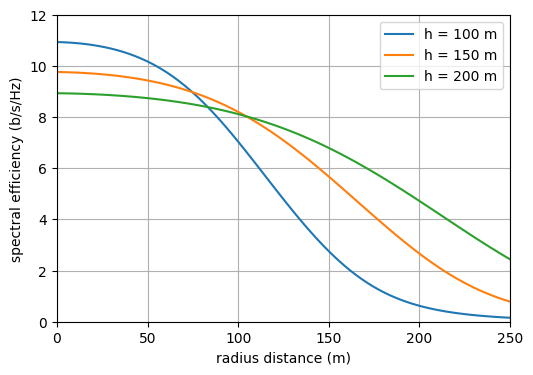

In [11]:
n_points = 100
zmax, zmin = z_max, z_min
xuav, yuav = 0, 0
xaxis = np.linspace(0, boundary, n_points)
yaxis = np.zeros(n_points)
alpha = 1 / (n_users * requesting_rate)         # bandwidth allocated equally to each active user 
print(f"bw allocation (alpha) = {alpha: .3f}")
print(f"bw per user = {alpha * channel_bandwidth / 1e6: .1f} MHz")


def cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav):
    '''Calculate the downlink throughput w.r.t. the relative position of users'''
    chgain = np.zeros(n_points)
    chcapa_Mb = np.zeros(n_points)
    chcapa_bpsHz = np.zeros(n_points)
    for i in range(0,n_points):
        chgain[i] = cal_channel_fading_gain(xaxis[i], yaxis[i], xuav, yuav, zuav)
        chcapa_Mb[i], chcapa_bpsHz[i] = cal_channel_capacity_Mb(chgain[i], alpha)
    return chcapa_Mb, chcapa_bpsHz


# Channel Capacity (Mb) vs Radius Distance 
zuav_list = [100, 150, 200]
radius_dist = np.sqrt((xaxis-xuav)**2+(yaxis-yuav)**2)  
fig, ax = plt.subplots(figsize=(5,3.5))
for zuav in zuav_list:
    ax.plot(radius_dist, cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav)[0], label=f'h = {zuav:.0f} m')
for lambd_Mb in ON_data_arrival_mean_Mb: 
    ax.plot(radius_dist, lambd_Mb*np.ones(radius_dist.shape), '--k')
plt.axvline(x=boundary/2, color='k', linestyle='--')
ax.set(xlabel='radius distance (m)', ylabel='downlink rate [Mbps]')
plt.tight_layout(pad=0)
plt.grid(True)
plt.legend(ncol=1)
plt.ylim(bottom=0, top=np.ceil(plt.ylim()[1]))
plt.xlim(left=radius_dist[0], right=radius_dist[-1])
plt.savefig(os.path.join(sim_folder_path, 'channel-capa-vs-radius-distance.png'), bbox_inches='tight')
plt.show()


# Spectral Efficiency (bps/Hz) vs Radius Distance
zuav_list = [100, 150, 200]
radius_dist = np.sqrt((xaxis-xuav)**2+(yaxis-yuav)**2)  
fig, ax = plt.subplots(figsize=(5,3.5))
for zuav in zuav_list:
    ax.plot(radius_dist, cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav)[1], label=f'h = {zuav:.0f} m')
ax.set(xlabel='radius distance (m)', ylabel='spectral efficiency (b/s/Hz)')
plt.tight_layout(pad=0)
plt.grid(True)
plt.legend(ncol=1)
plt.ylim(bottom=0, top=np.ceil(plt.ylim()[1]))
plt.xlim(left=radius_dist[0], right=radius_dist[-1])
plt.savefig(os.path.join(sim_folder_path, 'spactral-efficiency-vs-radius-distance.png'), bbox_inches='tight')
plt.show()


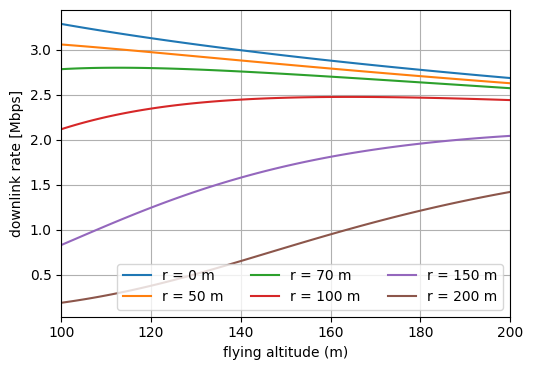

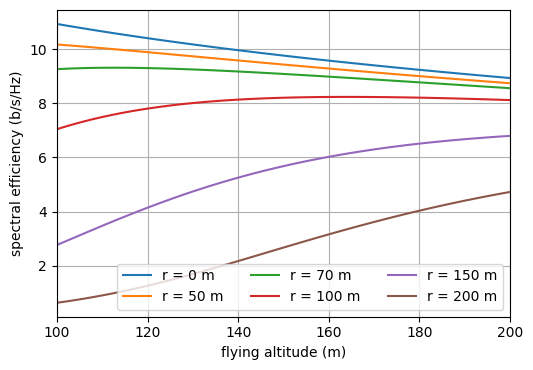

In [12]:
ulocs = [(0,0), (50,0), (70,0), (100,0), (150,0), (200,0)]
zuav_vec = np.linspace(zmin, zmax, n_points)


def cal_capacity_xyuser(xuser, yuser, zuav_vec):
    chgain = np.zeros(n_points)
    chcapa_Mb = np.zeros(n_points)
    chcapa_bpsHz = np.zeros(n_points)
    for i in range(0,n_points):
        chgain[i] = cal_channel_fading_gain(xuser, yuser, xuav, yuav, zuav_vec[i])
        chcapa_Mb[i], chcapa_bpsHz[i] = cal_channel_capacity_Mb(chgain[i], alpha)
    
    return chcapa_Mb, chcapa_bpsHz


# Donwlink Rate (Mbps) w.r.t. Flying Altitude (m)
fig, ax = plt.subplots(figsize=(5,3.5))
for uloc in ulocs: 
    ax.plot(
        zuav_vec, cal_capacity_xyuser(uloc[0], uloc[1], zuav_vec)[0],
        label=f'r = {np.sqrt(uloc[0]**2+uloc[1]**2):.0f} m'
    )
ax.set(xlabel='flying altitude (m)', ylabel='downlink rate [Mbps]')
plt.tight_layout(pad=0)
plt.grid(True)
plt.xlim(left=zuav_vec[0], right=zuav_vec[-1])
plt.legend(ncol=3)
plt.savefig(os.path.join(sim_folder_path, 'channel-capa-vs-flying-altitude.png'), bbox_inches='tight')
plt.show()


# Spectral Efficiency (bps/Hz) w.r.t. Flying Altitude (m)
fig, ax = plt.subplots(figsize=(5,3.5))
for uloc in ulocs: 
    ax.plot(
        zuav_vec,cal_capacity_xyuser(uloc[0], uloc[1], zuav_vec)[1],
        label=f'r = {np.sqrt(uloc[0]**2+uloc[1]**2):.0f} m'
    )
ax.set(xlabel='flying altitude (m)', ylabel='spectral efficiency (b/s/Hz)')
plt.tight_layout(pad=0)
plt.grid(True)
plt.xlim(left=zuav_vec[0], right=zuav_vec[-1])
plt.legend(ncol=3)
plt.savefig(os.path.join(sim_folder_path, 'spactral-efficiency-vs-flying-altitude.png'), bbox_inches='tight')
plt.show()

In [13]:
# Export channel model data to an excel file
d_dict = {'radius distance (m)': radius_dist}
for zuav in zuav_list: 
    d_dict[f'z={zuav}'] = cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav)[0]
df = pd.DataFrame(d_dict)
df.to_excel(os.path.join(sim_folder_path,'channel-capacity-Mbps.xlsx'))
print(f'Exported to {sim_folder_path}')

Exported to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10


# Simulation
- The UAVs and users move round within the target zone 
- Channel condition fluctuation due to user movement
- Queue evolves based on arrival traffic and channel throughput

### Bandwidth Allocation

##### linprog

In [14]:
# from scipy.optimize import linprog 

# def allocate_bandwidth(load_Mb, chcapa_Mb_ref, mask, alpha_min):
#     ''' 
#     Optimize the bandwidth allocation based on the downlink load using linear programming
#     Params: 
#         load_Mb: Q_i(t) + A_i(t), shape=(n_users,)
#         chcapa_Mb_ref: shape=(n_users,), maximum drate if the user occupy the whole channel 
#         mask: shape=(n_users,), denote users of interest (=1), i.e., active and belongs to the considered cluster
#     Return: 
#         alpha: the optimal bs allocation, shape=(n_users,), in range [0,1]
    
#     Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
#     '''
#     n_users = len(mask)
#     c = (-1) * load_Mb * chcapa_Mb_ref * mask    # 1-D array 
#     A_ub = np.ones(shape=(1, n_users))           # must be a 2-D array 
#     b_ub = [1]                                   # 1-D array 
#     bounds = [(alpha_min,1) for i in range(0,n_users)]
#     options = {'maxiter':100}
#     res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, options=options)
#     return res.x, res.status, res.nit, res.message  

# n_users = 5
# load_Mb = np.array([50, 0, 30, 4, 1]) # np.arange(0,5)+10
# chcapa_Mb_ref = [1, 2, 1, 20, 1]
# mask = np.ones(shape=(n_users,))
# alpha_min = 0 # 1/(4*n_users)
# x, status, nit, message = allocate_bandwidth(load_Mb, chcapa_Mb_ref, mask, alpha_min)
# print(f'load_Mb: {load_Mb}')
# print(x)
# print(f'status: {status}, {message}')
# print(f'# of iterations: {nit}')


# # # (2) UAV Updates: Movement and Energy Consumption  
# # for uav in uavs: 
# #     uav.x[t], uav.y[t], uav.z[t] = uav.x[0], uav.y[0], uav.z[0] 
    
# # # (2.1) UAV: Allocate channel bandwidth to users 
# # chcapa_Mb_ref = np.zeros(shape=(n_users,))          # the maximum drate if the user occupy the whole channel, i.e., alpha=1
# # for id, user in enumerate(users): 
# #     cid = cids[id]      # id of the user's cluster  
# #     chgain_tmp = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
# #     chcapa_Mb_ref = cal_channel_capacity_Mb(channel_gain=chgain_tmp, alpha=1)

# # for cid, uav in enumerate(uavs):   
# #     mask = isActive_all & (cids==cid)            # users that are active and belong to the considered cluster, shape=(n_users,) 


##### demand-based

In [15]:
def allocate_bandwidth_based_on_demand(load_Mb, mask):
    ''' 
    Greedily allocation the channel based on the downlink demand (Q_i(t) + A_i(t))
    Params: 
        load_Mb: the downlink demand, Q_i(t) + A_i(t), shape=(n_users,)
        mask: shape=(n_users,), denote users of interest (=1), i.e., active and belongs to the considered cluster
    Return: 
        alpha: the optimal bs allocation, shape=(n_users,), in range [0,1]
    '''
    load_Mb_masked = load_Mb*mask
    alpha = (load_Mb_masked)/np.sum(load_Mb_masked)
    
    return alpha 


In [16]:
# # Comment the following cell in simulation
# n_users_test = 5
# load_Mb = np.array([50, 0, 30, 4, 1]) 
# mask = np.array([0,1,0,0,1])
# alpha_min = 0 # 1/(4*n_users)
# x = allocate_bandwidth_based_on_demand(load_Mb, mask)
# print(x)

##### equal

In [17]:
def allocate_bandwidth_equal_to_active_users(is_active_allusers): 
    alpha = is_active_allusers*1/np.sum(is_active_allusers)
    return alpha 

def allocate_bandwidth_equal_fixed(n_users): 
    return np.ones(n_users)/n_users

# 1. STATIONARY

In [18]:
# Initiate the UAV Swarm 
uavswarm_stationary = [UAV(name= f'UAV {i} (Stationary)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=0, speedz_max=0) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_stationary = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_stationary, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# Alias for ease of code maintenance 
uavs = uavswarm_stationary
users = users_stationary          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)    # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0 
    
    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1),
                           np.expand_dims(yaxis_all[:,t], axis=1),
                           np.zeros(shape=(n_users,1))))                    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    if t==0:  # clustering at t=0 
        cids0 = cids.copy()
    
    # # (2) Bandwidth allocation based on the traffic demand 
    # alpha_uavs = np.zeros(shape=(n_uavs, n_users))      # shape=(n_uavs, n_users)
    # for cid, uav in enumerate(uavs):   
    #     mask = isActive_all & (cids==cid)               # users that are active and belong to the considered cluster, shape=(n_users,) 
    #     alpha_uavs[cid] = allocate_bandwidth_based_on_demand(queue_length_Mb+traffic_Mb, mask)
    # assert np.all(np.sum(alpha_uavs>0, axis=0) <= 1), "Each user should be associated to exactly one UAV-BS"
    # bw_alloc_all = np.sum(alpha_uavs, axis=0)              # shape=(n_users,)
    
    # # (2) Bandwidth Allocation: allocate equally among active users (qlen + new traffic > 0) 
    # bw_alloc_all = allocate_bandwidth_equal_to_active_users(isActive_all)
    
    #  (2) Bandwidth Allocation: allocate equally among all users (regardless active or not)
    bw_alloc_all = allocate_bandwidth_equal_fixed(n_users)
    
    # (3) UAV Updates: Keep stationary at the first location 
    # for uav in uavs: 
    #     uav.x[t], uav.y[t], uav.z[t] = uav.x[0], uav.y[0], uav.z[0] 
        
    # (3) UAV Updates: Move toward the initial centroids (of t=0) 
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                dx, dy, dd, uav_speed = 0, 0, 0, 0  # no movement 
            else: 
                xc0, yc0 = np.mean(xaxis_all[cids0==cid,0]), np.mean(yaxis_all[cids0==cid,0])   
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc0, yc0)
                # uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max      # greedily move toward the centroid w/ vmax 
                uav_speed = np.min([dd/(uav_vxy_fixed*slot_len), 1])*uav_vxy_fixed
            
            uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            uav.z[t] = uav.z[0] 
            uav.p_propulsion[t] = cal_uav_propulsion_energy(V=uav_speed)[0]
        
    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]; cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]               
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 


t=0
t=100
t=200
t=300
t=400
t=500
t=600
t=700
t=800
t=900
t=1000


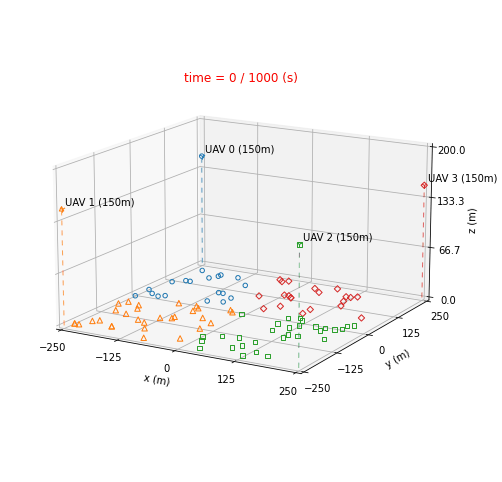

In [19]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(
    users=users_stationary, uavswarm=uavswarm_stationary, 
    xaxis_all=xaxis_all, yaxis_all=yaxis_all,
    dim='3d', t_max = 10, t_step = 10, 
    folder_name = 'dev/png2gif/stationary', gifname='swarm_stationary.gif', fps=2)
Image(filename=gif_path, width=500)

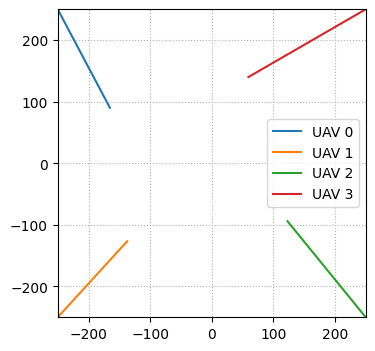

In [20]:
plt_uav_trajectory(uavs=uavswarm_stationary, name='stationary')

##### Testing the clustering algorithm

In [21]:
### For testing user clustering algo 
t = 0
loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1),
                        np.expand_dims(yaxis_all[:,t], axis=1),
                        np.zeros(shape=(n_users,1))))   
loc_uavs = np.array([[uav.x[t], uav.y[t], uav.z[t]] for uav in uavswarm_stationary])   # shape = (n_uavs, 3)
cluster_mat, cids, cluster_centers = kmeans_clustering(loc_users, loc_uavs)
print(cids); print(xaxis_all[cids==0,t].shape)
# print(cluster_mat[:5,:])
# print(cluster_centers)
# print(np.mean(xaxis_all[cluster_mat[:,0].astype(int),t]))


[0 2 2 1 1 1 2 0 3 1 0 0 1 3 2 2 0 0 0 2 2 0 1 2 2 1 1 3 2 2 3 1 3 2 2 3 1
 0 3 2 2 2 3 1 1 3 2 1 3 0 3 2 1 3 1 1 1 0 1 0 1 1 2 2 0 2 2 2 1 3 0 0 0 3
 1 2 2 3 1 1 2 0 2 1 2 2 3 1 2 1 3 3 1 3 0 1 3 1 0 3]
(19,)


# 2. CENTROID

In [22]:
# Initiate the UAV Swarm 
uav_swarm_centroid = [UAV(name= f'UAV {i} (Centroid)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_centroid = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_centroid, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# Alias for ease of code maintenance 
uavs = uav_swarm_centroid
users = users_centroid          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    
    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # # (2) Bandwidth allocation based on the traffic demand 
    # alpha_uavs = np.zeros(shape=(n_uavs, n_users))      # shape=(n_uavs, n_users)
    # for cid, uav in enumerate(uavs):   
    #     mask = isActive_all & (cids==cid)               # users that are active and belong to the considered cluster, shape=(n_users,) 
    #     alpha_uavs[cid] = allocate_bandwidth_based_on_demand(queue_length_Mb+traffic_Mb, mask)
    # assert np.all(np.sum(alpha_uavs>0, axis=0) <= 1), "Each user should be associated to exactly one UAV-BS"
    # bw_alloc_all = np.sum(alpha_uavs, axis=0)              # shape=(n_users,)
    
    # # (2) Bandwidth Allocation: allocate equally among active users (qlen + new traffic > 0) 
    # bw_alloc_all = allocate_bandwidth_equal_to_active_users(isActive_all)
    
    # # (2) Bandwidth Allocation: allocate equally among all users (regardless active or not)
    # bw_alloc_all = allocate_bandwidth_equal_fixed(n_users)
    
    # (2) Bandwidth Allocation: allocate equally among all users (regardless active or not)
    bw_alloc_all = allocate_bandwidth_equal_fixed(n_users)
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                dx, dy, dd, uav_speed = 0, 0, 0, 0  # no movement 
            else: 
                xc, yc = np.mean(xaxis_all[cids==cid,t]), np.mean(yaxis_all[cids==cid,t])   # centroid of the cluster 
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc, yc)
                # uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max      # greedily move toward the centroid w/ vmax 
                uav_speed = uav_vxy_fixed
            
            uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            uav.z[t] = uav.z[0]
            uav.p_propulsion[t] = cal_uav_propulsion_energy(V=uav_speed)[0]
    
    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 


t=0
t=100
t=200
t=300
t=400
t=500
t=600
t=700
t=800
t=900
t=1000


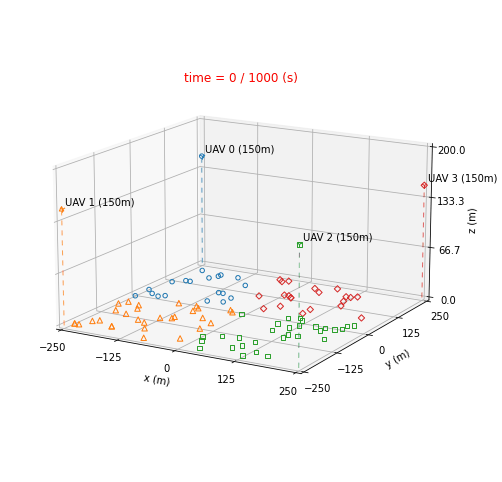

In [23]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(
    users=users_stationary, uavswarm=uav_swarm_centroid,
    xaxis_all=xaxis_all, yaxis_all=yaxis_all, 
    dim='3d', t_min=t_training_start, t_max = t_training_start+50, t_step = 5, 
    folder_name = 'dev/png2gif/centroid', gifname='swarm_centroid.gif', fps=2
)
Image(filename=gif_path, width=500)

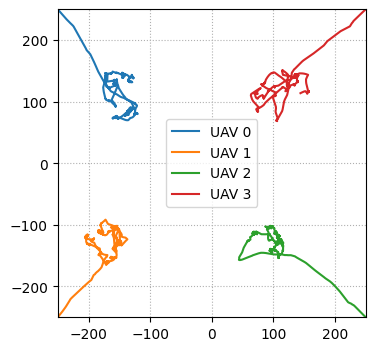

In [24]:
plt_uav_trajectory(uavs=uav_swarm_centroid, name='centroid')

# 3. CENTROID-ACTIVE (DEACTIVATED)
NOTE: 2D placement, the horizontal position of UAVs are unchanged

In [25]:
# # Initiate the UAV Swarm 
# uav_swarm_centroid_active = [UAV(name= f'UAV {i} (Centroid-Active)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
#                         xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# # Initiate users of the Stationary UAV Swarm with movements and traffic 
# users_centroid_active = [User(f'User {i}') for i in range(n_users)]
# load_user_properties(users_centroid_active, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# # Alias for ease of code maintenance 
# uavs = uav_swarm_centroid_active
# users = users_centroid_active          
    
# # Simulation starts!  
# for t in range(0, n_slots):         # t = timeslot
#     if t%100==0: 
#         print(f"t={t}")
#     # (0) Collect system statistics 
#     queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
#     traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
#     isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), True if qlen + traffic > 0
        
#     # (1) User Clustering: based on locations of users 
#     loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
#     loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
#                 else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
#     cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
#     # # (2) Bandwidth allocation based on the traffic demand 
#     # alpha_uavs = np.zeros(shape=(n_uavs, n_users))      # shape=(n_uavs, n_users)
#     # for cid, uav in enumerate(uavs):   
#     #     mask = isActive_all & (cids==cid)               # users that are active and belong to the considered cluster, shape=(n_users,) 
#     #     alpha_uavs[cid] = allocate_bandwidth_based_on_demand(queue_length_Mb+traffic_Mb, mask)
#     # assert np.all(np.sum(alpha_uavs>0, axis=0) <= 1), "Each user should be associated to exactly one UAV-BS"
#     # bw_alloc_all = np.sum(alpha_uavs, axis=0)              # shape=(n_users,)
    
#     # # (2) Bandwidth Allocation: allocate equally among active users (qlen + new traffic > 0) 
#     # bw_alloc_all = allocate_bandwidth_equal(isActive_all)

#     # (2) Bandwidth Allocation: allocate equally among all users (regardless active or not)
#     bw_alloc_all = allocate_bandwidth_equal_fixed(n_users)
    
#     # (3) UAV Updates: Movement and Energy Consumption  
#     if t > 0: 
#         for cid, uav in enumerate(uavs):        # cid = cluster id 
#             mask = (cids==cid) & isActive_all   # True if an user belongs to the cluster and is active  
#             if np.any(mask==True) and t>=t_training_start:      # If some users in the cluster are active   
#                 xc, yc = np.mean(xaxis_all[mask,t]), np.mean(yaxis_all[mask,t])   # centroid of the cluster    
#                 dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc, yc)
#                 # uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max
#                 uav_speed = uav_vxy_fixed
#                 uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
#                 uav.z[t] = uav.z[0] 
#             else:       # If no users is active, then the UAV makes no movement 
#                 uav.x[t], uav.y[t], uav.z[t] = uav.x[t-1], uav.y[t-1], uav.z[0]
    
#     # (4) User Updates  
#     for id, user in enumerate(users): 
#         user.cluster[t] = cids[id]
#         cid = cids[id]      # id of the user's cluster  
#         user.active_state[t] = isActive_all[id]
#         user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
#         user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
#         user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
#         qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
#         user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
#         user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
#         user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
#         user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 


In [26]:
# ### Animation of locations of UAVs and users
# gif_path = gen_animation_with_clusters(users=users_centroid_active, uavswarm=uav_swarm_centroid_active, dim='3d', t_min=t_training_start, t_max = t_training_start+50, t_step = 5, 
#                                        folder_name = 'dev/png2gif/centroid-active', gifname='swarm_centroid_active.gif', fps=2)
# Image(filename=gif_path, width=500)

# 4. PROPOSED
Regarding Overfitting: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/. 

In [27]:
# Initiate the UAV Swarm 
uav_swarm_proposed = [UAV(name= f'UAV {i} (Proposed)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init_proposed, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# UAV's flight controller 
uav_controller = UAV_Movement_Controller(boundary=boundary, grid_size=grid_size, uav_speedxy_max=uav_speedxy_max, n_decisions=n_decisions, 
                                         n_uavs=n_uavs, zmin=z_min, zmax=z_max, uav_speedz_max=uav_speedz_max)  
uav_controller.cal_channel_fading_gain = cal_channel_fading_gain 
uav_controller.cal_channel_capacity_Mb = cal_channel_capacity_Mb             
uav_controller.Vlya = lyapunov_param
uav_controller.gen_heatmap = gen_heatmap   
uav_controller.mos_func = mos_func

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_proposed = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_proposed, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# Alias for ease of code maintenance 
uavs = uav_swarm_proposed
users = users_proposed          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    capacity_Mb = np.array([user.channel_capacity_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), True if qlen + traffic > 0
    traffic_state_all = np.array([user.traffic_state[t] for user in users])
    
    # (1) User Clustering: based on locations of users 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # # (2) Bandwidth allocation based on the traffic demand 
    # alpha_uavs = np.zeros(shape=(n_uavs, n_users))      # shape=(n_uavs, n_users)
    # for cid, uav in enumerate(uavs):   
    #     mask = isActive_all & (cids==cid)               # users that are active and belong to the considered cluster, shape=(n_users,) 
    #     alpha_uavs[cid] = allocate_bandwidth_based_on_demand(queue_length_Mb+traffic_Mb, mask)
    # assert np.all(np.sum(alpha_uavs>0, axis=0) <= 1), "Each user should be associated to exactly one UAV-BS"
    # bw_alloc_all = np.sum(alpha_uavs, axis=0)              # shape=(n_users,)
    
    # # (2) Bandwidth Allocation: allocate equally among active users (qlen + new traffic > 0) 
    # bw_alloc_all = allocate_bandwidth_equal_to_active_users(isActive_all)
    
    # (2) Bandwidth Allocation: allocate equally among all users (regardless active or not)
    bw_alloc_all = allocate_bandwidth_equal_fixed(n_users)
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            uav_location = (uav.x[t-1], uav.y[t-1], uav.z[t-1])  
            user_locations = (xaxis_all[:,t], yaxis_all[:,t])    # a tupple of 2 arrays of shape (n_users,)
            mask = (cids==cid) & traffic_state_all       # True if an user belongs to the cluster and is active (i.e., qlen + traffic > 0)
            
            # (3.0) Collect user statistics
            # Only users belonging to the considered cluster are counted  
            # Random noise-added to avoid gradient vanishing 
            user_count_masked = 1e-6*np.random.rand(n_users) + np.ones(n_users)*mask  # shape = (n_users,)
            downlink_load_masked =  1e-6*np.random.rand(n_users) + queue_length_Mb*mask + traffic_Mb*mask  # shape = (n_users,)
            incoming_traffic_Mb_masked = 1e-6*np.random.rand(n_users) + traffic_Mb*mask      # shape = (n_users,) 
            ch_capacity_Mb_masked = 1e-6*np.random.rand(n_users) + capacity_Mb*mask    # shape = (n_users,)
            user_statistics = (downlink_load_masked,)  # ch_capacity_Mb_masked, shape = (n_users,3)
            normalization_coeff = (queue_norm_Mb,)   # user_counter_norm 
            
            # (3.1) Make a movement decision (dx, dy, and uav_speed) and (3.2) Update the replay memory
            if t >= t_training_start:
                dnn_prediction, best_decision = uav_controller.make_movement_decision(
                    uav_location, user_locations, user_statistics, normalization_coeff,
                    mask, incoming_traffic_Mb_masked, bw_alloc_all
                )
                dx, dy, vxy, dz, vz = best_decision         # dx and dy: -1 to 1, uav_speedxy: 0 to uav_speed_max, uav_speedz: -1 to 1 
            else: 
                # make no movement, do not update the replay memory 
                dx, dy, vxy, dz, vz = 0, 0, 0, 0, 0         
            
            # (3.3) Update the UAV location 
            xt, yt = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=vxy, slot_len=slot_len)
            uav.x[t] = adjust_location(xt, bound=boundary)
            uav.y[t] = adjust_location(yt, bound=boundary)
            zt = update_UAV_altitude(z0=uav.z[t-1], dz=dz, vz=vz, slot_len=slot_len)
            uav.z[t] = adjust_altitude(zt, zmin=z_min, zmax=z_max)
            uav.p_propulsion[t] = cal_uav_propulsion_energy(V=np.sqrt(vxy**2 + vz**2))[0]
            
        # (3.4) Retrain the DNN periodically 
        if (uav_controller.memory_counter_train >= uav_controller.min_samples_for_training) \
            and (t >= t_training_start) \
            and (t % training_interval==0):   # (uav_controller.memory_counter_train % uav_controller.training_interval == 0)\
            uav_controller.retrain_dnn()
    
    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_=user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 


t=0
t=100
t=200
t=300
t=400
t=500
t=600
t=700
t=800
t=900
t=1000


##### Animation

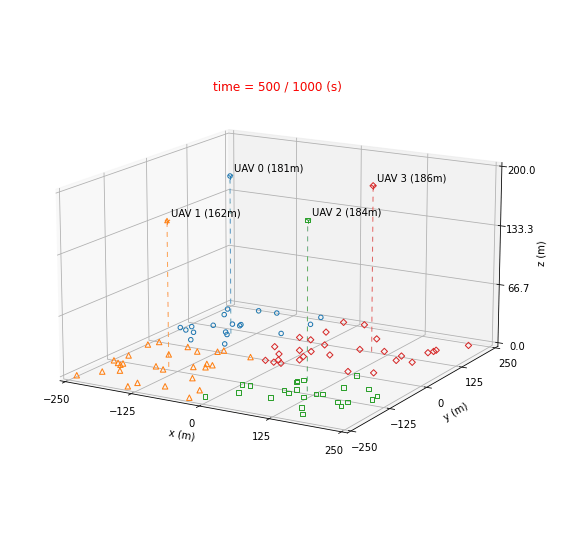

In [28]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(
    users=users_proposed, uavswarm=uav_swarm_proposed,
    xaxis_all=xaxis_all, yaxis_all=yaxis_all, 
    dim='3d', t_min=500, t_max = 510, t_step = 1, 
    folder_name = 'dev/png2gif/proposed', gifname='swarm_proposed.gif', fps=10, dpi=72, figsize=(7,7)
)
Image(filename=gif_path, width=400)

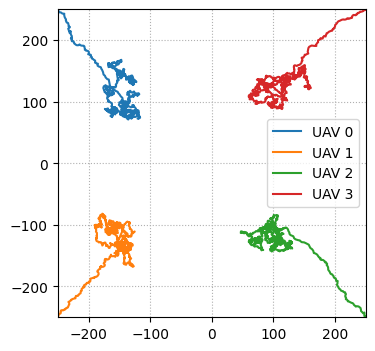

In [29]:
plt_uav_trajectory(uavs=uav_swarm_proposed, name='proposed')

##### UAV Altitude

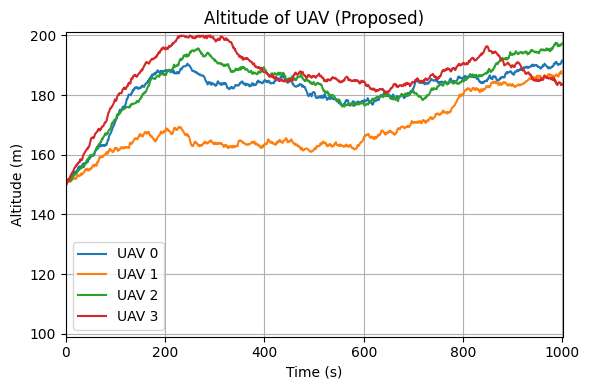

Exported altitude data to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\altitude-vstack.xlsx


In [30]:
# Plot the UAV altitude
fig, ax = plt.subplots(figsize=(6,4))
for uav in uav_swarm_proposed:
    plt.plot(uav.z, label=f'{uav.name[:5]}')
ax.set(xlabel="Time (s)", ylabel="Altitude (m)", title="Altitude of UAV (Proposed)")
ax.set(ylim=[z_min-1,z_max+1], xlim=[0,n_slots])
plt.legend(ncol=1); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path, 'uav_altitude_proposed.png'), dpi=72)
plt.show()

# Export to excel file
altitudes =  np.zeros(shape=(n_uavs,n_slots-t_training_start))
for id, uav in enumerate(uav_swarm_proposed): 
    altitudes[id] = uav.z[t_training_start:]
altitudes = altitudes.flatten()
altitudes_dict = {'altitude (m)':altitudes}
df = pd.DataFrame(altitudes_dict)
fpath = os.path.join(sim_folder_path, 'altitude-vstack.xlsx')
df.to_excel(fpath)
print(f'Exported altitude data to {fpath}')


In [31]:
### Create an animtion of UAV altitude 
# tmax = n_slots-1
# for t in range(t_training_start, tmax):
#     fig, ax = plt.subplots(figsize=(6,4))
#     for uav in uav_swarm_proposed:
#         plt.plot(uav.z[:t], label=f'{uav.name[:5]}')
#     ax.set(xlabel="Time (s)", ylabel="Altitude (m)", title=f"time = {t} / {n_slots-1} (s)")
#     ax.set(ylim=[z_min-1,z_max+1], xlim=[t_training_start,n_slots])
#     plt.legend(ncol=4); plt.grid(True); plt.tight_layout()
#     plt.savefig(os.path.join(sim_folder_path, f'gif_altitude/uav_altitude_proposed_t{t}.png'), dpi=150)
#     plt.close()

# # save all image into a list 
# images = []
# for t in range(t_training_start,tmax): 
#     image = imageio.v2.imread(os.path.join(sim_folder_path, f'gif_altitude/uav_altitude_proposed_t{t}.png'))
#     images.append(image)
        
# # combine all images into a GIF 
# path_to_gif = os.path.join(sim_folder_path, f'gif_altitude.gif')
# imageio.mimsave(path_to_gif, ims = images, fps = 1)  # ims = list of input images, [fps = frames per second]

##### Training history

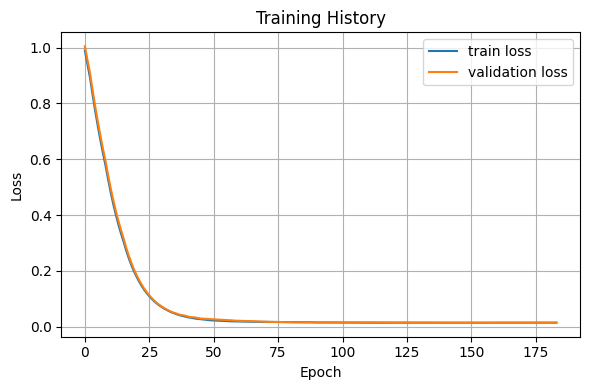

Exported training history to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\train history.xlsx


In [32]:
train_loss_hist = np.array(uav_controller.train_loss_history); 
train_loss_hist = np.delete(train_loss_hist,0)     
val_loss_hist = np.array(uav_controller.val_loss_history); 
val_loss_hist = np.delete(val_loss_hist,-1)  

# Plot training history
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(train_loss_hist, label='train loss')
plt.plot( val_loss_hist, label='validation loss')
ax.set(xlabel='Epoch', ylabel='Loss', title='Training History')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path, 'train-history.png'), bbox_inches='tight')
plt.show()


# Export to excel file
train_dict = {'train loss':train_loss_hist, 'validation loss':val_loss_hist}
df = pd.DataFrame(train_dict)
fpath = os.path.join(sim_folder_path, 'train history.xlsx')
df.to_excel(fpath)
print(f'Exported training history to {fpath}')


### DNN Summary

Model: "uav_controller"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_stat_heatmaps (InputLayer  [(None, 25, 25, 1)]  0          []                               
 )                                                                                                
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (None, 25, 25, 1)    0           ['user_stat_heatmaps[0][0]']     
                                                                                                  
 conv2d_3 (Conv2D)              (None, 23, 23, 32)   320         ['tf.reshape_1[0][0]']           
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 11, 11, 32)  0           ['conv2d_3[0][0]']  

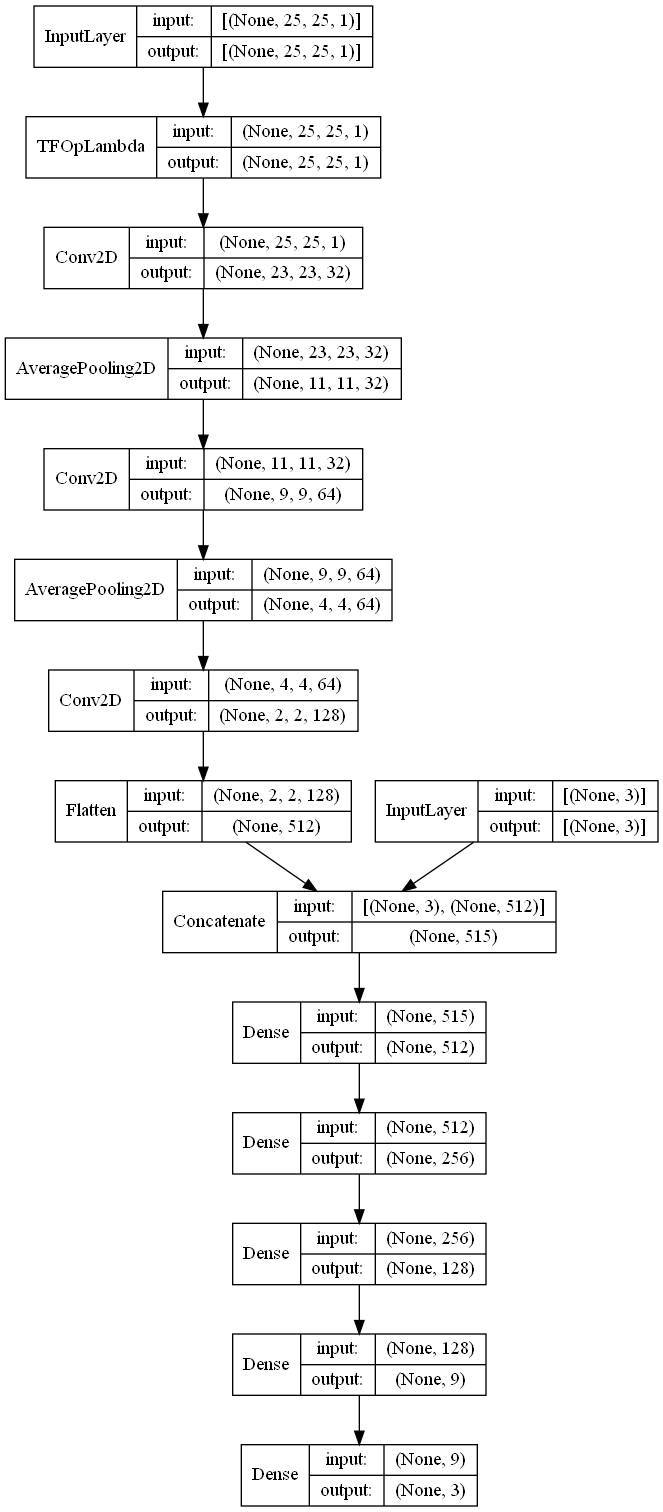

In [33]:
uav_controller = UAV_Movement_Controller(boundary=boundary, grid_size=grid_size, uav_speedxy_max=uav_speedxy_max, n_decisions=n_decisions, 
                                         n_uavs=n_uavs, zmin=z_min, zmax=z_max, uav_speedz_max=uav_speedz_max)  

uav_controller.model.summary()

from keras.utils.vis_utils import plot_model
plot_model(uav_controller.model, 
           to_file=os.path.join(sim_folder_path, 'dnn_model.png'), 
           show_shapes=True, 
           show_layer_names=False, 
           rankdir = 'TB',                  # 'TB': vertical plot, 'LR': horizontal plot.
           expand_nested = False)


# Performance Evaluation


In [34]:
# users_list = [users_stationary, users_centroid, users_centroid_active, users_proposed]  
# uavs_list = [uavswarm_stationary, uav_swarm_centroid, uav_swarm_centroid_active, uav_swarm_proposed] 
# names = ['Stationary', 'Centroid', 'Centroid (Active)', 'Proposed']

users_list = [users_stationary, users_centroid, users_proposed] 
uavs_list = [uavswarm_stationary, uav_swarm_centroid, uav_swarm_proposed] 
names = ['Stationary', 'Centroid', 'Proposed']

# users_list = [users_stationary, users_centroid, users_centroid_active]  
# uavs_list = [uavswarm_stationary, uav_swarm_centroid, uav_swarm_centroid_active] 
# names = ['Stationary', 'Centroid', 'Centroid (Active)']

# users_list = [users_proposed] 
# uavs_list = [uav_swarm_proposed] 
# names = ['Proposed']

# users_list = [users_stationary] 
# uavs_list = [uavswarm_stationary] 
# names = ['Stationary']

# users_list = [users_stationary, users_proposed] 
# uavs_list = [uavswarm_stationary, uav_swarm_proposed] 
# names = ['Stationary', 'Proposed']

xlim_tmax = n_slots+1


### Channel Capacity

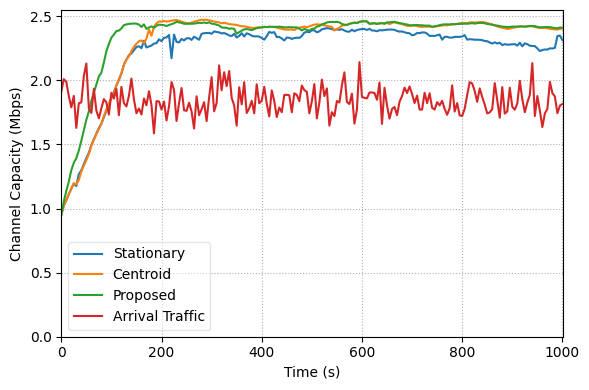

In [35]:
rolling_interval = 1 
tvec = np.arange(0,n_slots)
xlim_tmax = n_slots
t_step = 5                      # for the moving average of KPI 
dict_kpi = {}

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.channel_capacity_Mb for user in users])
    kpi_avg = np.mean(kpi_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_interval)      
    plt.plot(tvec[::t_step], kpi_mmean[::t_step], '-', markerfacecolor='None', label=fname)
    dict_kpi[names[i]+' (avg)'] = np.mean(kpi_all, axis=0) 
    dict_kpi[names[i]+' (sum)'] = np.sum(kpi_all, axis=0) 

traffic_mmean = export_moving_average(traffic_sum_Mb/traffic_state_sum, rolling_interval)
plt.plot(tvec[::t_step], traffic_mmean[::t_step], '-', markerfacecolor='None', label='Arrival Traffic')
dict_kpi['Traffic (avg)'] = traffic_sum_Mb/traffic_state_sum
dict_kpi['Traffic (sum)'] = traffic_sum_Mb

ax.set(xlabel='Time (s)', ylabel='Channel Capacity (Mbps)')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5, ncol=1)
plt.xlim([0,xlim_tmax])
plt.ylim(bottom=0)
fig.tight_layout()

plt.savefig(os.path.join(sim_folder_path,f'Channel_Capacity_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()

df_kpi = pd.DataFrame(dict_kpi)
df_kpi.to_excel(os.path.join(sim_folder_path, 'channel-capacity-of-all-methods.xlsx'))


### Queue Length

Figure: Moving Average, Min and Max of Queue Length of Active Users
Rolling interval = 1 s


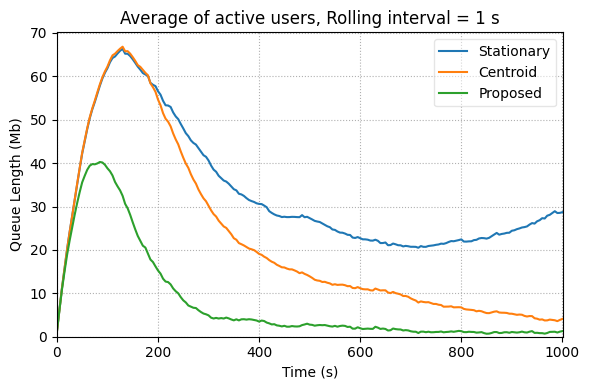

In [36]:
rolling_interval = 1 #ON_duration_mean_tslot
tvec = np.arange(0,n_slots)
xlim_tmax = n_slots
t_step = 5             # for the moving average of KPI 
xlim_tmin = 0 # t_training_start

print(f'Figure: Moving Average, Min and Max of Queue Length of Active Users')
print(f'Rolling interval = {rolling_interval} s')

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.queue_length_Mb for user in users])        # shape=(n_users,n_slots)
    active_state_all = np.array([user.active_state for user in users])         # shape=(n_users,n_slots)
    kpi_avg = np.sum(kpi_all, axis=0)/np.sum(active_state_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_intv=rolling_interval)          # Average Queue Length 
    plt.plot(tvec[xlim_tmin::t_step], kpi_mmean[xlim_tmin::t_step], '-', markerfacecolor='None', label=fname)
    # kpi_mmin = export_moving_min(kpi_avg,rolling_interval)
    # kpi_mmax = export_moving_max(kpi_avg,rolling_interval)
    # ax.fill_between(x=tvec[xlim_tmin::], y1=kpi_mmin[xlim_tmin::], y2=kpi_mmax[xlim_tmin::], alpha=0.2)
ax.set(xlabel='Time (s)', ylabel='Queue Length (Mb)', title=f'Average of active users, Rolling interval = {rolling_interval} s')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5)   
plt.xlim([xlim_tmin,xlim_tmax])
plt.ylim(bottom=0)
# plt.yscale('log')
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path,f'QueueLength_Rolling_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()


### Downlink Throughput 

Figure: Moving Average, Min and Max of Downlink Throughput of Active Users
Rolling interval = 60 s


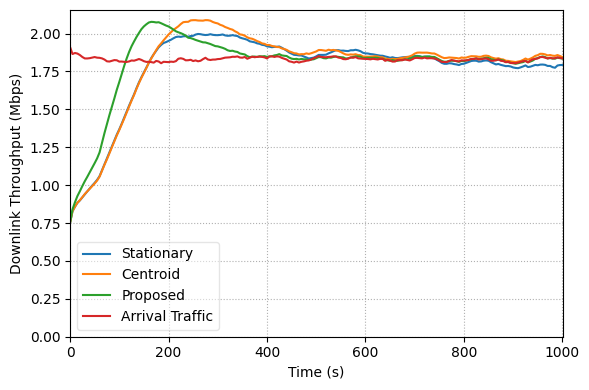

In [37]:
rolling_interval = 60 # ON_duration_mean_tslot
tvec = np.arange(0,n_slots)
xlim_tmax = n_slots
t_step = 5             # for the moving average of KPI 

print(f'Figure: Moving Average, Min and Max of Downlink Throughput of Active Users')
print(f'Rolling interval = {rolling_interval} s')

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.downlink_throughput_Mb for user in users])
    state_all = np.array([user.active_state for user in users])
    kpi_avg = np.sum(kpi_all, axis=0)/np.sum(state_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_interval)          # Average Queue Length 
    kpi_mmin = export_moving_min(kpi_avg,rolling_interval)
    kpi_mmax = export_moving_max(kpi_avg,rolling_interval)
    plt.plot(tvec[::t_step], kpi_mmean[::t_step], '-', markerfacecolor='None', label=fname)
    # ax.fill_between(x=tvec, y1=kpi_mmin, y2=kpi_mmax, alpha=0.2)

traffic_active = traffic_sum_Mb/traffic_state_sum
traffic_mmean = export_moving_average(traffic_active, rolling_interval)
traffic_mmin = export_moving_min(traffic_active, rolling_interval)
traffic_mmax = export_moving_max(traffic_active, rolling_interval)
plt.plot(tvec[::t_step], traffic_mmean[::t_step], '-', markerfacecolor='None', label='Arrival Traffic')
# ax.fill_between(x=tvec, y1=traffic_mmin, y2=traffic_mmax, alpha=0.2)

ax.set(xlabel='Time (s)', ylabel='Downlink Throughput (Mbps)')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5, ncol=1)
plt.xlim([0,xlim_tmax])
plt.ylim(bottom=0)
fig.tight_layout()

plt.savefig(os.path.join(sim_folder_path,f'Throughut_Rolling_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()


### User Heatmap

In [38]:
'''Utility Functions'''

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure  
import matplotlib.image as image 
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids, grid_size, cb_label, fname, average=False, marker_sz=15, dpi=600, mask_active=None, figsize=(5,5), vmax=None): 
    ### Scatter plot of the location of users and uavs  
    markersz_vec =marker_sz*np.ones(len(val_all))  #  marker_sz + 50*val_all/np.mean(val_all[mask_active==1]) 
    mfig = Figure(figsize=figsize, dpi = 300, facecolor='none')
    mcanvas = FigureCanvasAgg(mfig)
    m_ax = mfig.add_subplot(111)
    
    img = image.imread(os.path.join(os.getcwd(), 'dev', 'phone2.png'))
    imagebox = OffsetImage(img, zoom=0.035, alpha=0.5)
    for id in range(n_users):
        ab = AnnotationBbox(imagebox, (xaxis_all[id][t], yaxis_all[id][t]), frameon=False)
        m_ax.add_artist(ab) 
        # m_ax.scatter(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker='o', edgecolors='k', color='none', s=markersz_vec[id]) 
    
    img = image.imread(os.path.join(os.getcwd(), 'dev', 'drone1.png'))
    imagebox = OffsetImage(img, zoom=0.04)
    for id, uav in enumerate(uavswarm):
        ab = AnnotationBbox(imagebox, (uav.x[t], uav.y[t]), frameon=False)
        m_ax.add_artist(ab) 
        # m_ax.plot(uav.x[t], uav.y[t], linestyle='None', marker='s', label=uav.name,
        #          markeredgecolor='b', markerfacecolor='w', markersize=15, markeredgewidth=1)
        m_ax.text(uav.x[t]+12, uav.y[t]+12, f'UAV {id}', {'color':'k', 'fontsize':'x-large'}, 
                  bbox=dict(facecolor='white', edgecolor='none', pad=0.5, alpha=0.7))
    m_ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    m_ax.margins(0); m_ax.axis('off'); mfig.tight_layout(pad=0)
    mcanvas.draw()
    buf = mcanvas.buffer_rgba()
    x = np.asarray(buf)

    ### Heatmap 
    hm_loc = gen_heatmap(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)
    if average==True: 
        hm_loc2 = gen_heatmap(xaxis_all[:,t], yaxis_all[:,t], np.ones(n_users), 1, n_grids, grid_size) # mask_active, np.ones(n_users)
        hm_loc /=  np.maximum(hm_loc2, 1)
    
    ### Layered Image: a heatmap on top of a scatter plot 
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)  # figsize=(5,4.1)
    if vmax is None: 
        im0 = ax.imshow(hm_loc, interpolation='bessel', cmap=mpl.cm.coolwarm, alpha=0.85) # interpolation= 'none, 'bessel' 'mitchell' 'bicubic'  'gaussian' 'hamming' 'quadric' 'lanczos'; cmap= 'viridis' 'jet'; cmap=matplotlib.cm.coolwarm
    else: 
        im0 = ax.imshow(hm_loc, interpolation='none', cmap='viridis', alpha=0.85, vmin=0, vmax=vmax)
    im1 = ax.imshow(x, extent=im0.get_extent(), alpha=1)   
    cb = plt.colorbar(im0, fraction=0.046, pad=0.04, shrink=0.4)   # color bar
    cb.set_label(label=cb_label, size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    plt.tight_layout(pad=1)
    ax.set_title(label=f'time = {t} / {n_slots-1} (s)', fontdict={'color': 'red'}, y=1.05)
    
    ### Option 1: add xticks (0,1,2,...) and yticks (A,B,C,...)
    ax.set_xticks(ticks=np.arange(0,n_grids), labels=np.arange(0,n_grids)); ax.set_yticks(ticks=np.arange(0,n_grids), labels=['A','B','C','D','E']); 
    
    ### Option2: crop the image, work best for image without ticks 
    # ax.set_xticks([]); ax.set_yticks([]) 
    # fig.subplots_adjust(bottom=0.02, left=0.01, top=0.98, right=0.85) # right=0.87
    
    plt.savefig(fname,  dpi=dpi, bbox_inches='tight', pad_inches=0.5)
    plt.close()
    print(f'Exported {fname} to {os.getcwd()}')
    

def gen_traffic_heatmap_animation(users, uavswarm, t_start, t_stop, t_step=1, n_grids=5, marker_sz=30, folder_name='dev/png2gif_heatmap', gifname='animation', fps=3, dpi=72, figsize=(6,6), vmax=None):
    grid_size = int(2*boundary/n_grids)
    
    # Generate a heatmap for each time slot as a pgn image 
    for t in range(t_start, t_stop+1, t_step):
        val_all = np.array([user.queue_length_Mb[t-1] for user in users])
        val_all += np.array([user.arrival_traffic_Mb[t] for user in users])
        mask_active = np.array([user.active_state[t] for user in users])
        norm_val = 1
        fpath = os.path.join(folder_name, f'layered_heatmap_queueNtraffic_t{t}.png')
        
        export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids, grid_size, f'Downlink Demand (Mb)', fpath, average=False, marker_sz=marker_sz, mask_active=mask_active, dpi=dpi, figsize=figsize, vmax=vmax)

    # Generate a gif image
    images = []
    for t in range(t_start,t_stop,t_step): 
        image = imageio.v2.imread(os.path.join(folder_name, f'layered_heatmap_queueNtraffic_t{t}.png'))
        images.append(image)
    
    path_to_gif = os.path.join(folder_name, gifname)
    imageio.mimsave(path_to_gif, ims = images, fps = fps)  # ims = list of input images, [fps = frames per second]
    
    return path_to_gif

In [39]:
'''Gen an animation of user heatmap'''

# users = users_proposed
# uavswarm = uav_swarm_proposed
# gifname = 'traffic_heatmap.gif' 

# gif_path = gen_traffic_heatmap_animation(users, uavswarm, t_start=t_training_start, t_stop=t_training_start+100, t_step=10, n_grids=5, marker_sz=40, 
#                                          folder_name='dev/png2gif_heatmap/proposed', gifname=gifname, fps=1, dpi=72, figsize=(7,7), vmax=50)
# Image(filename=gif_path, width=400)


'Gen an animation of user heatmap'

In [40]:
'''Gen a snapshot of user heatmap'''

t = 200
n_grids2 = 5
grid_size2 = int(2*boundary/n_grids2)
marker_sz = 30

# users = users_stationary
# uavswarm = uavswarm_stationary
users = users_proposed
uavswarm = uav_swarm_proposed
# users = users_centroid
# uavswarm = uav_swarm_centroid
# users = users_centroid_active
# uavswarm = uav_swarm_centroid_active



Exported c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\layered_heatmap_queueNtraffic.png to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev


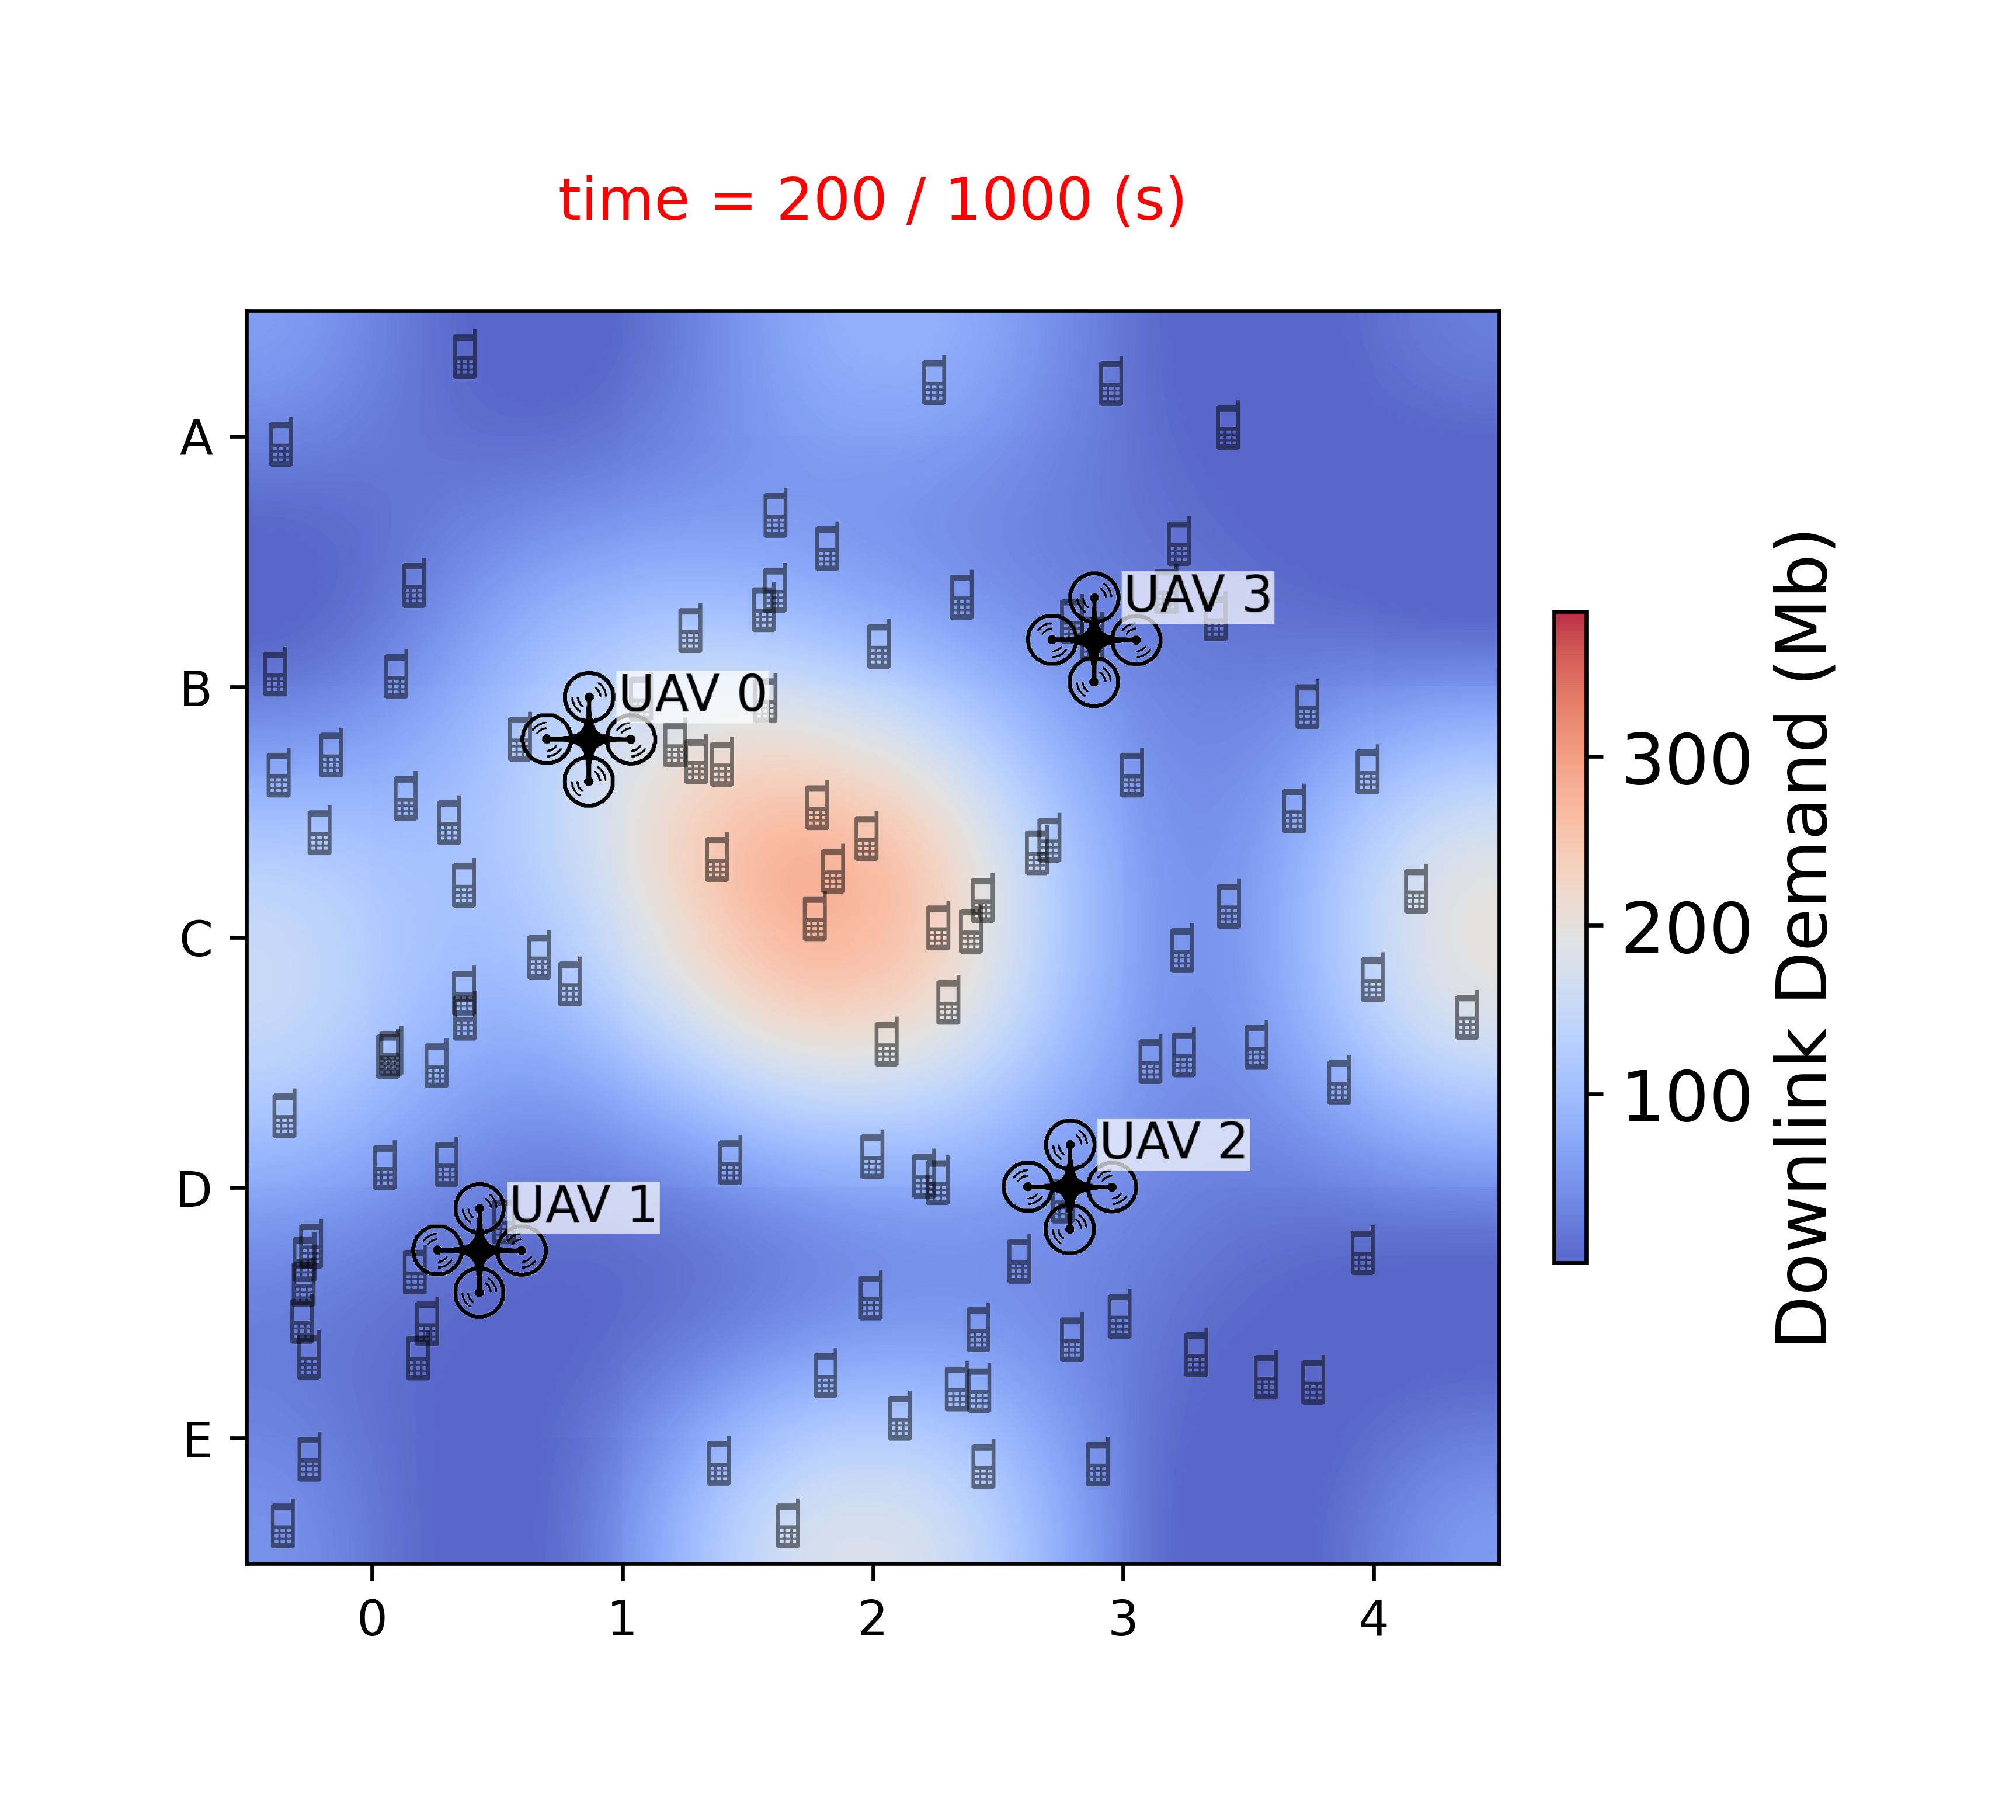

In [41]:
################ Donwlink Traffic (Demand) ################ 

val_all = np.array([user.queue_length_Mb[t-1] for user in users]) + np.array([user.arrival_traffic_Mb[t] for user in users])
mask_active = np.array([user.active_state[t] for user in users])
norm_val = 1
fname = 'layered_heatmap_queueNtraffic.png'

export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, f'Downlink Demand (Mb)', 
                     os.path.join(sim_folder_path, fname), average=False, marker_sz=marker_sz, mask_active=mask_active)
Image(filename=os.path.join(sim_folder_path, fname), width=400)


Exported c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\layered_heatmap_location.png to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev


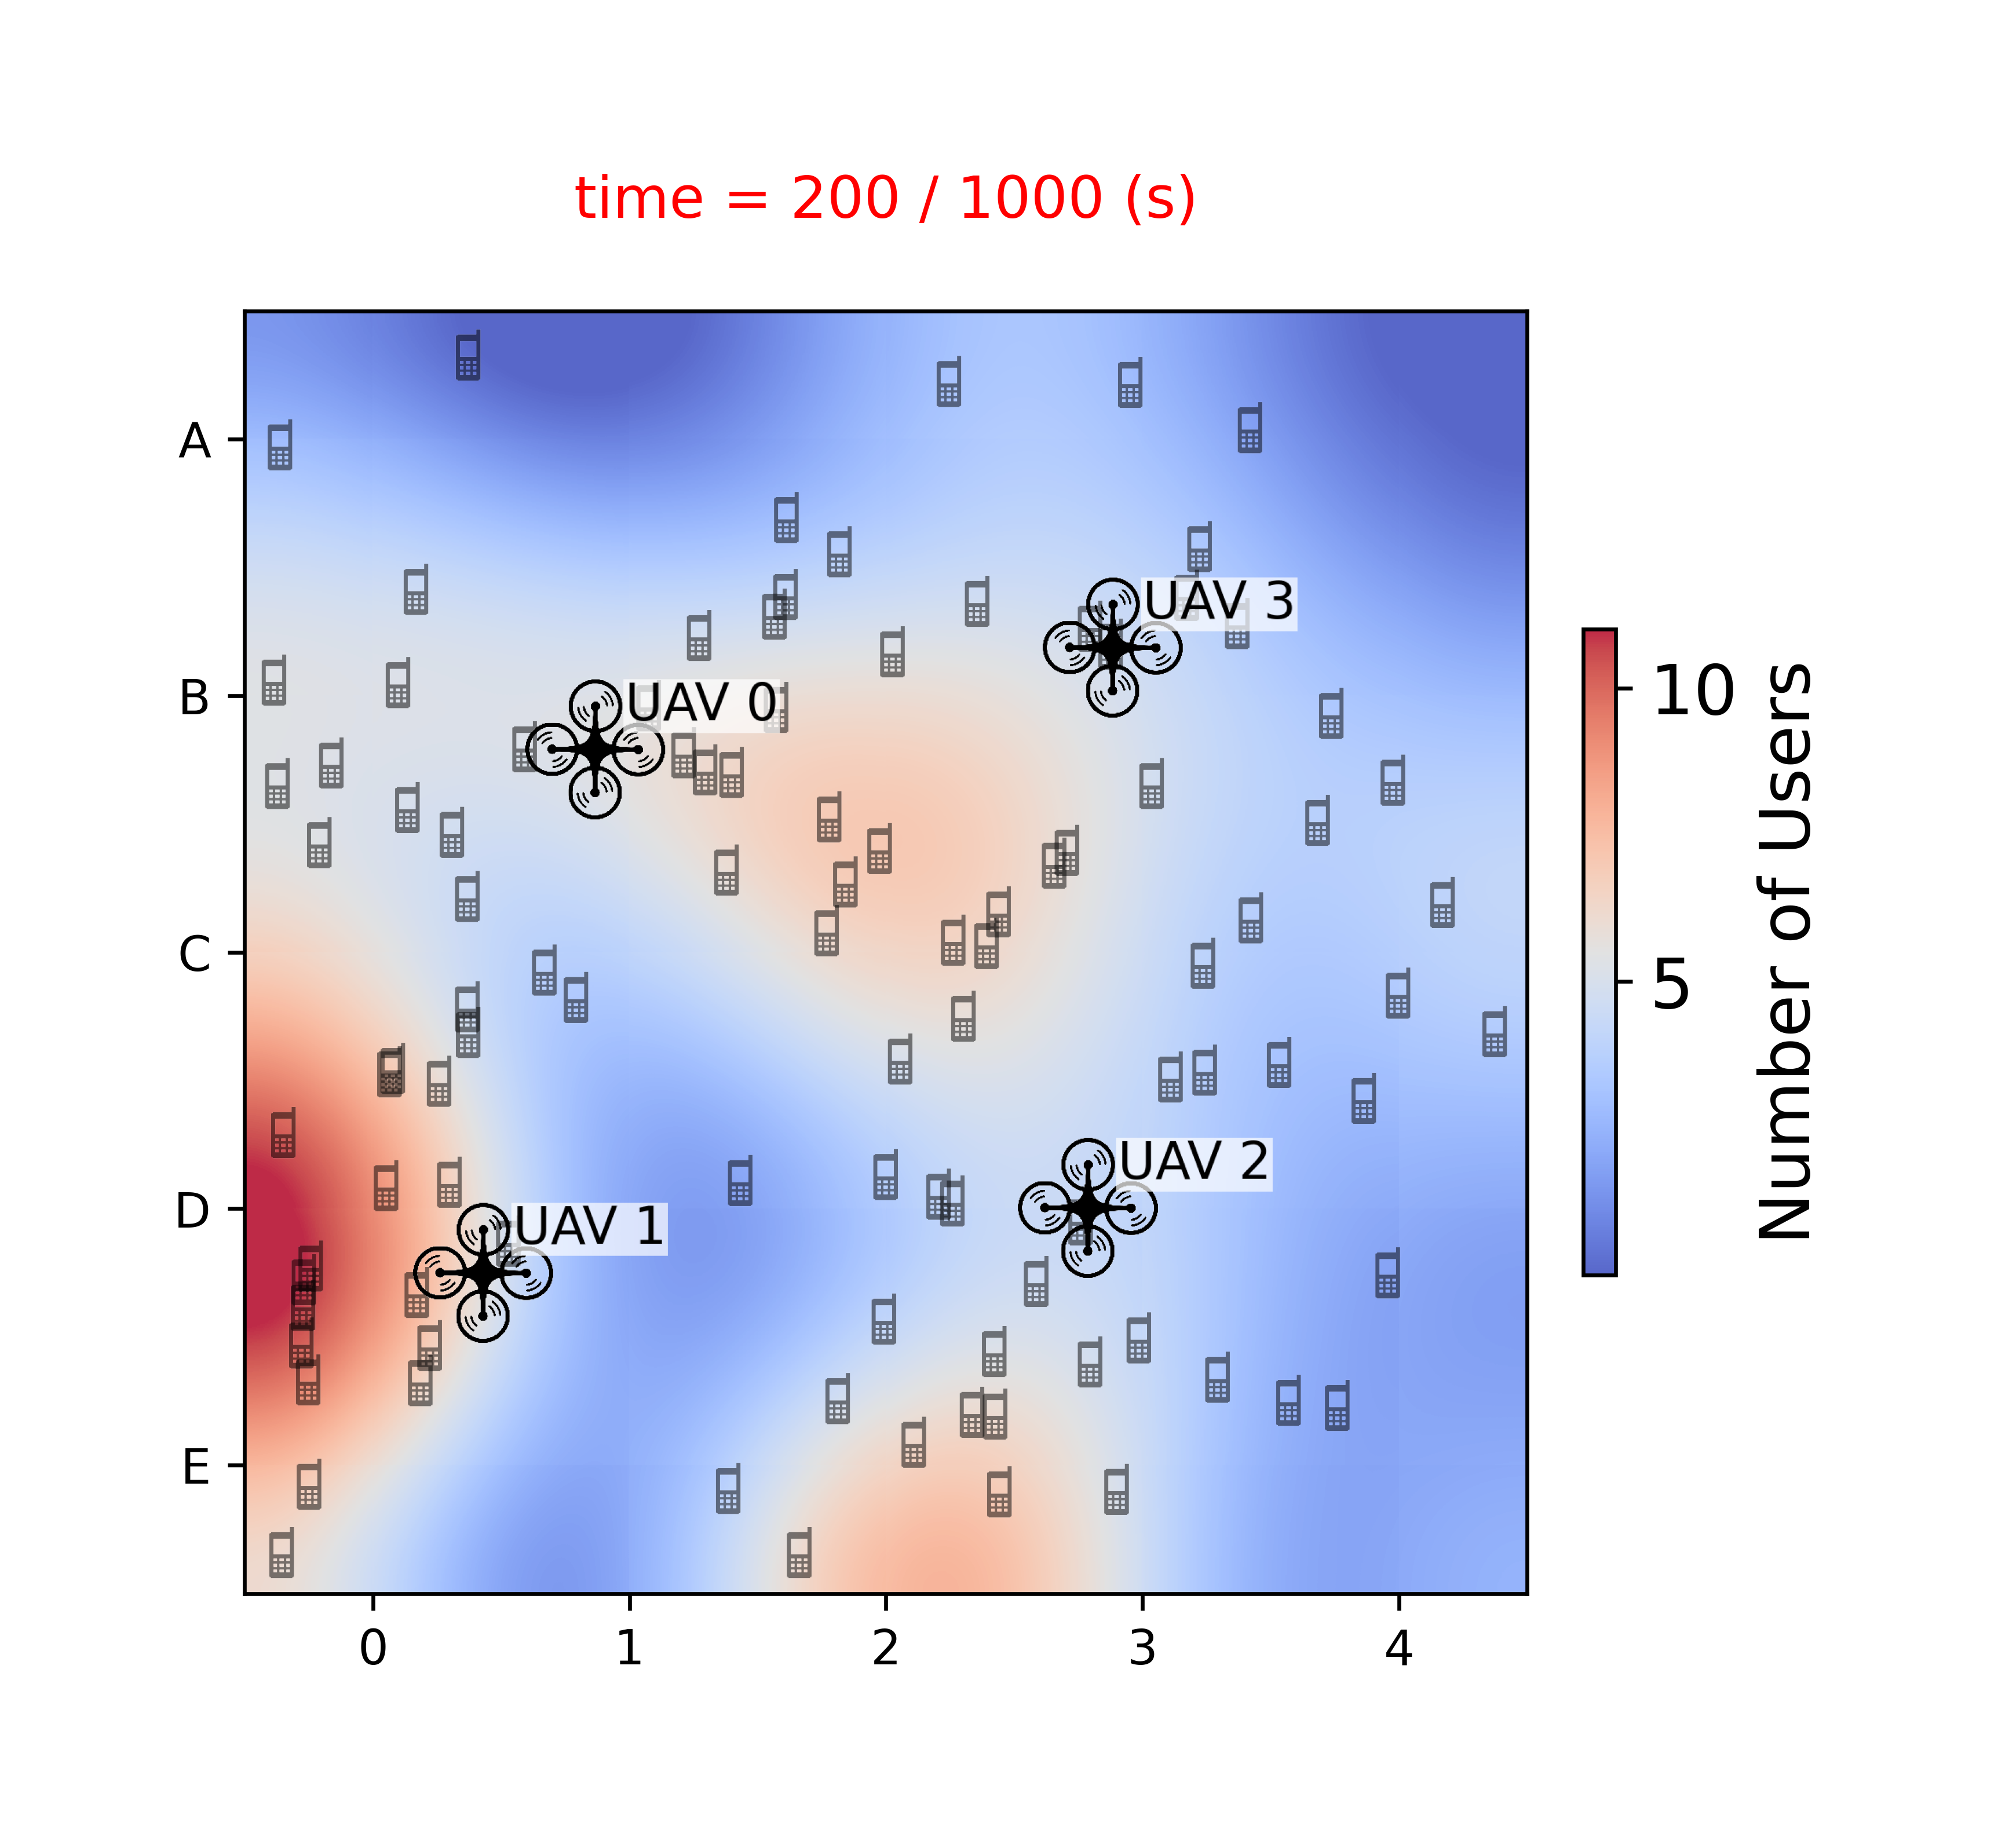

In [42]:
################ User Distribution ################ 

val_all = np.ones(n_users)
norm_val = 1
fname = 'layered_heatmap_location.png'

export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, f'Number of Users', 
                     os.path.join(sim_folder_path, fname), average=False, marker_sz=marker_sz)
Image(filename=os.path.join(sim_folder_path, fname), width=400)


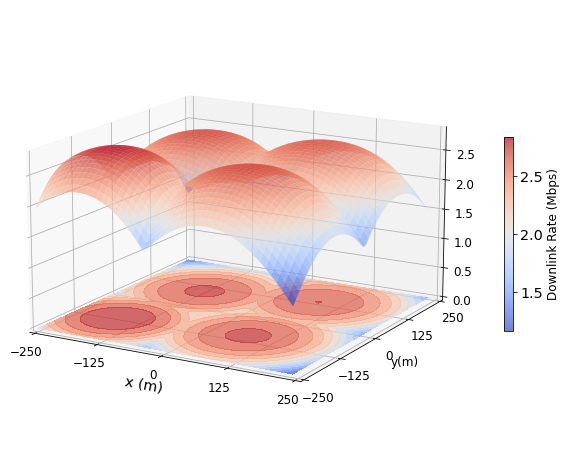

In [43]:
'''Plot 3D donwlink rate (channel capacity)'''

from mpl_toolkits.mplot3d import Axes3D

step_ = 10 
x = np.arange(-boundary, boundary, step=step_)
y = np.arange(-boundary, boundary, step=step_)
n_points = len(x)
X, Y = np.meshgrid(x,y)
Z = np.zeros(shape=(n_uavs, n_points, n_points))                        # the downlink data rate 
mask_active = np.array([user.active_state[t] for user in users])        # the indicator of active users 
alpha_ = 1/np.sum(mask_active)

for cid, uav in enumerate(uavswarm): 
    for i in range(n_points):         
        for j in range(n_points):
            cg = cal_channel_fading_gain(X[i,j], Y[i,j], uav.x[t], uav.y[t], uav.z[t])
            Z[cid][i][j] = cal_channel_capacity_Mb(channel_gain=cg, alpha=alpha_)[0]
            
Z_ = np.amax(Z, axis=0)

# Plotting 
fig = plt.figure(figsize=(8,8))    # figsize in inch
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_, cmap=mpl.cm.coolwarm, alpha=0.7, linewidth=1) # linewidth=0, antialiased=False; cmap=matplotlib.cm.coolwarm, 'viridis'
cb = fig.colorbar(surf, shrink=0.35, fraction=0.046, pad=0.08)    # fraction=0.046, pad=0.04
cb.set_label(label='Downlink Rate (Mbps)', size='large')
cb.ax.tick_params(labelsize='x-large')
cset = ax.contourf(X, Y, Z_, zdir='z', offset=0, levels=15, alpha=0.7, cmap=mpl.cm.coolwarm) # cmap=matplotlib.cm.coolwarm, 'viridis'

ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))  
ax.set_zlim(bottom=0)
ax.set_xlabel('x (m)', fontsize='x-large') # ax.set(xlabel='x (m)', ylabel='y(m)')
ax.set_ylabel('y(m)', fontsize='large')
ax.tick_params(labelsize='large')
ax.view_init(elev=15)   # azim=120
ax.set_box_aspect([1,1,0.6])        # ax.set_aspect('auto') 
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path, 'mos-3d.png'), bbox_inches='tight', dpi=72)
plt.savefig(os.path.join(sim_folder_path, 'mos-3d.pdf'), bbox_inches='tight', dpi=600)
plt.close()

# Image show
Image(os.path.join(sim_folder_path, 'mos-3d.png'), width=400)


Exported c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\layered_heatmap_capacity.png to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev


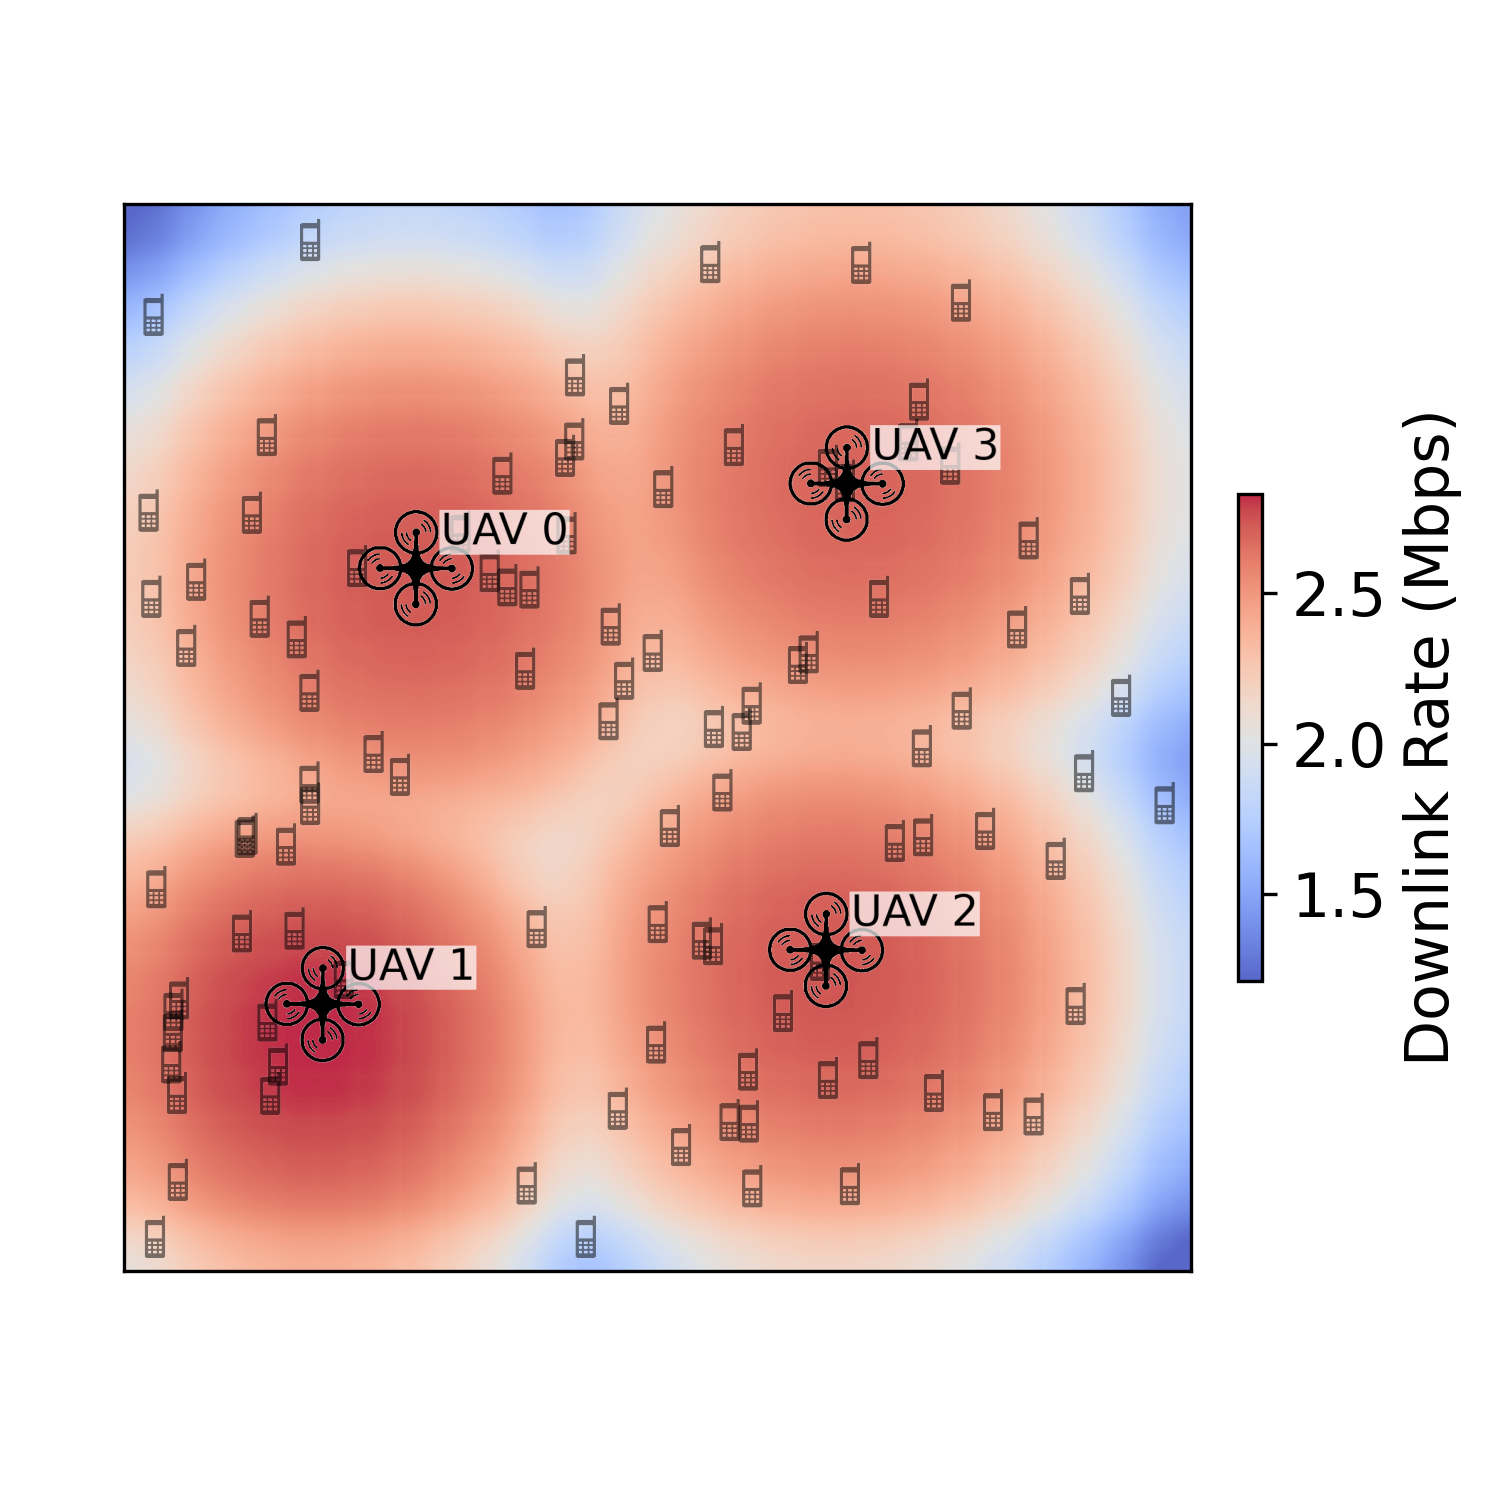

In [44]:
'''Plot 2D downlink rate'''

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure  
import matplotlib.image as image 
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def export_layered_image_drate(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids, grid_size, cb_label, fname, average=True, figsize=(5,5), dpi=300, marker_sz=15): 
    ### Scatter plot of the location of users and uavs  
    markersz_vec = marker_sz*np.ones(len(val_all)) # 10 + 50*val_all/np.max(val_all)
    mfig = Figure(figsize=figsize, dpi = dpi, facecolor='none')
    mcanvas = FigureCanvasAgg(mfig)
    m_ax = mfig.add_subplot(111)
    
    img = image.imread(os.path.join(os.getcwd(), 'dev', 'phone2.png'))
    imagebox = OffsetImage(img, zoom=0.035, alpha=0.5)
    for id in range(n_users):
        ab = AnnotationBbox(imagebox, (xaxis_all[id][t], yaxis_all[id][t]), frameon=False)
        m_ax.add_artist(ab) 
        # m_ax.scatter(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker='o', edgecolors='k', color='none', s=markersz_vec[id]) 
    
    img = image.imread(os.path.join(os.getcwd(), 'dev', 'drone1.png'))
    imagebox = OffsetImage(img, zoom=0.04)
    for id, uav in enumerate(uavswarm):
        ab = AnnotationBbox(imagebox, (uav.x[t], uav.y[t]), frameon=False)
        m_ax.add_artist(ab) 
        # m_ax.plot(uav.x[t], uav.y[t], linestyle='None', marker='s', label=uav.name,
        #          markeredgecolor='b', markerfacecolor='w', markersize=15, markeredgewidth=1)
        m_ax.text(uav.x[t]+12, uav.y[t]+12, f'UAV {id}', {'color':'k', 'fontsize':'x-large'}, 
                  bbox=dict(facecolor='white', edgecolor='none', pad=0.5, alpha=0.7))
    m_ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    m_ax.margins(0); m_ax.axis('off'); mfig.tight_layout(pad=0)
    mcanvas.draw()
    buf = mcanvas.buffer_rgba()
    x = np.asarray(buf)

    # Heatmap 
    hm_loc = gen_heatmap(X.flatten(), Y.flatten(), Z_.flatten(), 1, n_grids, grid_size)
    hm_loc2 = gen_heatmap(X.flatten(), Y.flatten(), np.ones(len(X.flatten())), 1, n_grids, grid_size) # mask_active, np.ones(n_users)
    hm_loc /=  np.maximum(hm_loc2, 1)
    
    # Layered Image: a heatmap on top of a scatter plot 
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im0 = ax.imshow(hm_loc, interpolation='bessel', cmap=mpl.cm.coolwarm, alpha=0.85) # interpolation= 'bessel' 'mitchell' 'bicubic'  'gaussian' 'hamming' 'quadric' 'lanczos'; cmap= 'viridis' 'jet', cmap=matplotlib.cm.coolwarm
    im1 = ax.imshow(x, extent=im0.get_extent(), alpha=1)   
    cb = plt.colorbar(im0, fraction=0.046, pad=0.04, shrink=0.35)   # color bar 
    cb.set_label(label=cb_label, size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    plt.tight_layout(pad=1)
    ax.set_xticks([]); ax.set_yticks([]); 
    # fig.subplots_adjust(bottom=0.02, left=0.01, top=0.98, right=0.87)
    plt.savefig(fname); plt.close()
    print(f'Exported {fname} to {os.getcwd()}')
    
    
n_grids2 = 25;  grid_size2 = int(2*boundary/n_grids2); marker_sz = 30
fname = 'layered_heatmap_capacity.png'
export_layered_image_drate(uavswarm, xaxis_all, yaxis_all, t, np.ones(n_users), np.ones(n_users), n_grids2, grid_size2, 
                           'Downlink Rate (Mbps)', os.path.join(sim_folder_path, fname), average=True, marker_sz=marker_sz)
Image(filename=os.path.join(sim_folder_path, fname), width=400)


### QoE Score (MOS)
NOTE: if a user is inactive, their MOS equals `np.nan` and will not be counted.

In [45]:
'''Plot percentile (eg, 50%) of MOS'''

# rolling_interval = 1 # int(ON_duration_mean_tslot)
# xlim_tmin = 0 # int(t_training_start)
# xlim_tmax = n_slots
# t_step = 5                         # for the moving average of KPI 
# q = 50

# fig, ax = plt.subplots(figsize=(6,4))   
# for i in range(0,len(users_list)):
#     users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
#     mos_all = np.array([user.mos for user in users])        # shape=(n_users,n_slots)
#     kpi_mmean = export_moving_average(np.nanpercentile(mos_all, q=q, axis=0), rolling_intv=rolling_interval)   
#     plt.plot(tvec[xlim_tmin:xlim_tmax:t_step], kpi_mmean[xlim_tmin:xlim_tmax:t_step], '-|', label=fname)

#     # df = pd.DataFrame(mos_all)  
#     # ax.fill_between(x = np.arange(0,n_slots), 
#     #                 y1 = df.transpose().apply(np.nanmin, axis=1).values,
#     #                 y2 = df.transpose().apply(np.nanmax, axis=1).values, 
#     #                 alpha=0.1)
    
# ax.set(xlabel='Time (s)', ylabel=f'Percentile ({q}%) QoE score (MOS)', title=f'Average over Active Users, Rolling interval = {rolling_interval} s',
#        xlim = [xlim_tmin, xlim_tmax], ylim = [1,5.1]) # ylim = [4,5], yticks = np.arange(4,5+.1,0.5)   
# plt.legend(ncol=2)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



'Plot percentile (eg, 50%) of MOS'

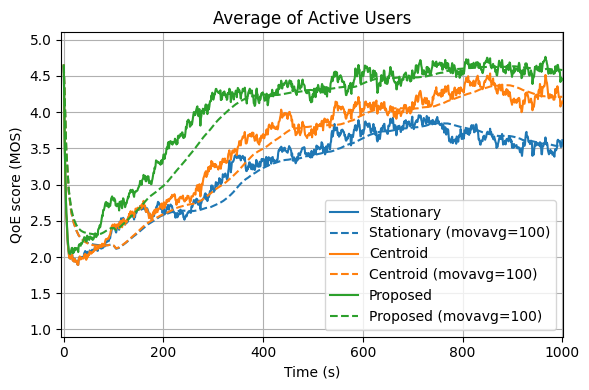

In [46]:
'''Plot the average MOS over time''' 

rolling_interval = 100 # int(ON_duration_mean_tslot)
xlim_tmin = 0 # int(t_training_start)
xlim_tmax = n_slots
t_step = 5                         # for the moving average of KPI 


fig, ax = plt.subplots(figsize=(6,4))   
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    mos_all = np.array([user.mos[xlim_tmin:] for user in users])        # shape=(n_users,n_slots)
    kpi_mmean = export_moving_average(np.nanmean(mos_all, axis=0), rolling_intv=rolling_interval) 
    plt.plot(tvec, np.nanmean(mos_all, axis=0), '-', label=fname, color=colors[i])
    plt.plot(tvec[xlim_tmin::t_step], kpi_mmean[::t_step], linestyle='--', label=fname+f' (movavg={rolling_interval})', color=colors[i])
    
ax.set(xlabel='Time (s)', ylabel='QoE score (MOS)', title=f'Average of Active Users',
       xlim = [xlim_tmin-5, xlim_tmax]) # , yticks = np.arange(4,5+.1,0.5)  
ax.set_ylim(bottom=0.9, top=5.1) 
plt.legend(ncol=1)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path,f'MOS_Rolling_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()


In [47]:
'''Number of users with QoE < QoE_thres'''

# rolling_interval = int(ON_duration_mean_tslot)
# xlim_tmin = 0
# mos_th = 4

# fig, ax = plt.subplots(figsize=(6,4))   
# for i in range(0,len(users_list)):
#     users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
#     mos_all = np.array([user.mos for user in users])        # shape=(n_users,n_slots)
#     kpi_mmean = export_moving_average(np.nansum(mos_all<mos_th, axis=0)/(n_users-np.sum(np.isnan(mos_all),axis=0)), rolling_intv=rolling_interval)   
#     ax = sns.lineplot(x=tvec[xlim_tmin::], y=kpi_mmean[xlim_tmin::]*100, label=fname)
    
# ax.set(xlabel='Time (s)', ylabel=f'Ratio of MOS < {mos_th:.1f}, %', title=f'Rolling interval = {rolling_interval} s',
#        xlim = [xlim_tmin, xlim_tmax])   
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


'Number of users with QoE < QoE_thres'

In [48]:
'''Export MOS of all users over time''' 
users_ = [users_proposed, users_centroid, users_stationary] 
names_ = ['proposed', 'centroid', 'stationary']
for id in range(len(users_)):
    for i in range(0,len(users_list)):
        mos_all = np.array([user.mos for user in users_[id]])        # shape=(n_users,n_slots)
        
    df_mos = pd.DataFrame(mos_all)               
    df_mos.to_excel(os.path.join(sim_folder_path, f'mos_all_users_over_time_{names_[id]}.xlsx'))
    
print(f'Exported to {sim_folder_path}')

Exported to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10


### QoE Fairness

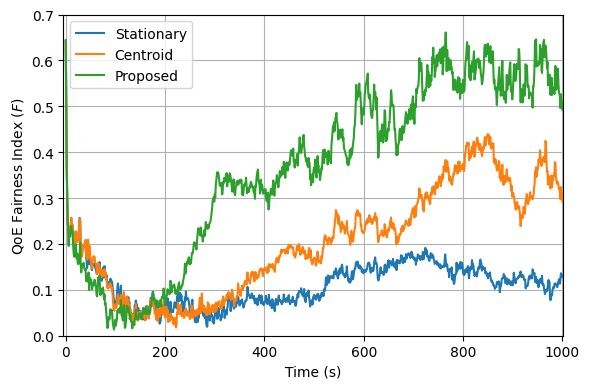

In [69]:
rolling_interval = 100 # int(ON_duration_mean_tslot)
xlim_tmin = 0   # int(t_training_start)
xlim_tmax = n_slots
t_step = 5                         # for the moving average of KPI 


fig, ax = plt.subplots(figsize=(6,4))   
for i in range(0,len(users_list)):
    users, uavs, fname = users_list[i], uavs_list[i], names[i]
    mos_all = np.array([user.mos[xlim_tmin:] for user in users])        # shape=(n_users, n_slots)
    kpi = qoe_fairness(mos_all, axis=0)     # shape=(n_slots)
    kpi_mavg = export_moving_average(kpi, rolling_intv=rolling_interval)
    plt.plot(tvec, kpi, '-', label=fname, color=colors[i])
    # plt.plot(
    #     tvec[xlim_tmin::t_step], kpi_mavg[::t_step],
    #     linestyle='--', label=fname+f' (movavg={rolling_interval})', color=colors[i]
    # )
    
ax.set(xlabel='Time (s)',
       ylabel='QoE Fairness Index ($F$)',
       xlim = [xlim_tmin-5, xlim_tmax]
) # , yticks = np.arange(4,5+.1,0.5)  
ax.set_ylim(bottom=0, top=.7) 
plt.legend(ncol=1)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(sim_folder_path,f'QoE_Fairness_Rolling_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()

### Propulsion Energy

Figure: Moving Average, Mean of Propulsion Power of UAVs
Rolling interval = 1 s


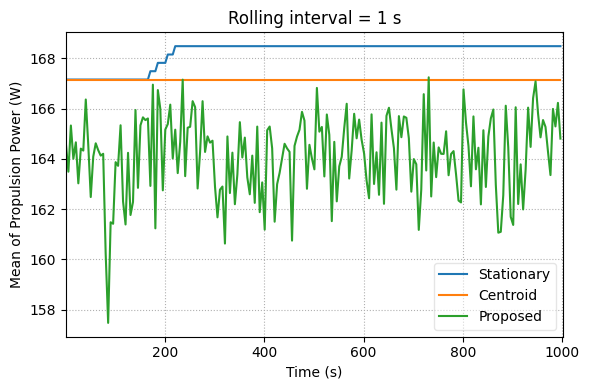

In [50]:
rolling_interval = 1                #ON_duration_mean_tslot
tvec = np.arange(0,n_slots)
xlim_tmax = n_slots
t_step = 5                          # for the moving average of KPI 
xlim_tmin = 1                       # t_training_start

print(f'Figure: Moving Average, Mean of Propulsion Power of UAVs')
print(f'Rolling interval = {rolling_interval} s')

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([uav.p_propulsion for uav in uavs])                      # shape=(n_uavs,n_slots)
    kpi_mean = np.mean(kpi_all, axis=0)
    kpi_mmean = export_moving_average(kpi_mean, rolling_intv=rolling_interval)   # Average Queue Length

    # kpi_mean = np.mean(kpi_all, axis=0)
    # cumsum = np.cumsum(kpi_mean)     # cummulative sum

    plt.plot(tvec[xlim_tmin::t_step], kpi_mmean[xlim_tmin::t_step], '-', markerfacecolor='None', label=fname)
    # plt.plot(cumsum)
ax.set(xlabel='Time (s)', ylabel='Mean of Propulsion Power (W)', title=f'Rolling interval = {rolling_interval} s')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5)   
plt.xlim([xlim_tmin,xlim_tmax])
# plt.ylim(bottom=150)
# plt.yscale('log')
fig.tight_layout()
plt.savefig(os.path.join(sim_folder_path, f'PropulsionPower_Rolling_{rolling_interval}s.png'), bbox_inches='tight')
plt.show()


### System Snapshot

In [51]:
# t = 2612
# marker_sz = 10
# xy_add = 7
# mdir_uav_proposed = 7       # in # of time slots 
# mdir_user = 70

# for t in range(0, 500, 5):
    
#     '''Calcualte downlink throughput'''
#     alpha = np.ones(shape=(n_users)) * 1/n_users        # equal bandwidth allocation
#     qlen_prev_Mb = uav_proposed.queue_length_Mb[:,t-1] if t > 0 else 0
#     arrival_Mb = uav_proposed.arrival_traffic_Mb[:,t]

#     chgains_downlink = np.zeros(shape=(n_users,))
#     channel_capacity_Mb = np.zeros(shape=(n_users,))
#     qlen_next_Mb = np.zeros(shape=(n_users,))
#     throughput_dict = {}


#     for server in servers: 
#         downlink_throughput_Mb = np.zeros(shape=(n_users,))
#         for i, user in enumerate(users): 
#             chgains_downlink[i] = cal_channel_fading_gain(user.x[t], user.y[t], server.x[t], server.y[t], server.altitude)  
#             channel_capacity_Mb[i] = cal_channel_capacity_Mb(chgains_downlink[i],  alpha=alpha[i])
#             qlen_next_Mb[i] = update_queue_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
#                                                 arrival_Mb=arrival_Mb[i],
#                                                 departure_Mb=channel_capacity_Mb[i])
#             downlink_throughput_Mb[i] = cal_downlink_throughput_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
#                                                                 arrival_Mb=arrival_Mb[i],
#                                                                 channel_capacity_Mb=channel_capacity_Mb[i])  
#         throughput_dict[server.name] = downlink_throughput_Mb 
#         print(throughput_dict[server.name])


#     '''Plot figures'''
#     plt.figure(figsize=(5,5))    # figsize in inch 

#     # Plot the boundary 
#     radius = boundary  # in meter
#     plt.plot(-radius, radius, 'sw', markersize=1)
#     plt.plot(-radius, -radius, 'sw', markersize=1)
#     plt.plot(radius, radius, 'sw', markersize=1)
#     plt.plot(radius, -radius, 'sw', markersize=1)

#     ### Plot users' location
#     server = uav_proposed
#     for uid, user in enumerate(users):
#         plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz)
#         plt.annotate(text=f'{server.queue_length_Mb[uid,t-1] + server.arrival_traffic_Mb[uid,t]:.1f}', 
#                     xy=(user.x[t]+xy_add, user.y[t]+xy_add))
#         # plt.arrow(x=user.x[t], y=user.y[t], dx=user.x[t+mdir_user]-user.x[t], dy=user.y[t+mdir_user]-user.y[t],
#         #       color='k', head_width=15, head_length=15, overhang=1)
#     plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz, label='mobile users')

#     ### Plot the UAV located at O (fixed)
#     server = uav_fixed 
#     plt.plot(server.x[t], server.y[t], linestyle="None", marker='o', color='tab:blue', label=server.name, markersize=marker_sz)
#     throughput_sum = np.sum(throughput_dict[server.name])
#     plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:blue')

#     ### Plot the centroid of users' location 
#     # plt.plot(x_centroid[t], y_centroid[t], '^b', label='centroid of all users')
#     # print(x_centroid[t], y_centroid[t])

#     ### Plot the UAV movement (following centroids of all users)
#     server = uav_centroid
#     plt.plot(server.x[t], server.y[t], linestyle='None', marker='s', color='tab:orange', label=server.name, markersize=marker_sz)
#     throughput_sum = np.sum(throughput_dict[server.name])
#     plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+5, server.y[t]+xy_add+5), color='tab:orange')
#     # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_user]-server.x[t], dy=server.y[t+mdir_user]-server.y[t],
#     #           color='b', head_width=15, head_length=15, overhang=1)

#     ### Plot the UAV movement (proposed)
#     server = uav_proposed
#     plt.plot(server.x[t], server.y[t], linestyle='None', marker='^', color='tab:green', label=server.name, markersize=marker_sz)
#     throughput_sum = np.sum(throughput_dict[server.name])
#     plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:green')
#     # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_uav_proposed]-server.x[t], dy=server.y[t+mdir_uav_proposed]-server.y[t],
#     #           color='r', head_width=15, head_length=15, overhang=1)

#     plt.xlim(-270, 270)
#     plt.ylim(-270, 270)
#     plt.xticks(np.arange(-250, 251, step=100))
#     plt.yticks(np.arange(-250, 251, step=100))
#     plt.legend(loc='upper right')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
#     plt.grid(True)
#     plt.xlabel('x (m)')
#     plt.ylabel('y (m)')
#     plt.savefig(os.path.join(os.getcwd(), 'png', f"problem_illustration_t{t}.png"), bbox_inches='tight', dpi=600)


# Export data

### Metadata

In [52]:
# Export system parameters to a text file (metadata) 
metadata={
    "num of slots": f'{int(n_slots)} (s)', 
    "num of users" : n_users, 
    "num of uavs" : n_uavs, 
    "channel bandwidth":f'{channel_bandwidth/1e6} MHz', 
    # "fixed bandwidth for one user" : f'{bw_1user/1e6:.1f} MHz', 
    "pTx_downlink" : f'{pTx_downlink*1000} mW', 
    'boundary (m)': f'{2*boundary}x{2*boundary}',  
    'average moving speed of users':speed_user_avg, 
    "Arrival rate (Mbps)": lambd_Mb, 
    "ON_data_arrival_mean_Mb":ON_data_arrival_mean_Mb,
    'min session time (for MOS)': f'{ss_min} s',
    'max session time (for MOS)': f'{ss_max} s',
    "Vlya": lyapunov_param,
    "initial UAV location": init_locations_uav, 
    "z_init (m)":z_init,
    "z_min (m)":z_min, 
    "z_max (m)":z_max, 
    "uav_speedxy_max (m/s)":uav_speedxy_max,
    "uav_speedz_max (m/s)":uav_speedz_max,
    "learning rate": uav_controller.learning_rate, 
    'regularization parameter':uav_controller.regular_para, 
    "num of actions": n_decisions,
    "training interval": f'{training_interval} (s)',
    "memory size (training)": uav_controller.memory_size,
    "memory size (validation)":uav_controller.val_memory_size, 
    "batch size": uav_controller.batchSize_, 
    "min samples for training": uav_controller.min_samples_for_training, 
    "std_var for generating actions (exploration)": uav_controller.std_var_vxvyvz_explore,
    "std_var for generating actions (exploitation)": uav_controller.std_var_vxvyvz_exploit,
    "mean duration of ON state":ON_duration_mean_tslot,
    "mean duration of OFF state":OFF_duration_mean_tslot
}

with open(os.path.join(sim_folder_path, "simulation_parameters.txt"), 'w') as f: 
    for key, value in metadata.items(): 
        f.write('%s: %s\n' % (key, value)) 

### Export KPI data to xlsx files

In [53]:
import pandas as pd 

def export_kpi_over_time(users, sim_folder_path, method_name):
    active_state_all = np.array([user.active_state for user in users])          # shape=(n_users,n_slots)
    traffic_state_all = np.array([user.traffic_state for user in users])
    traffic_Mb_all = np.array([user.arrival_traffic_Mb for user in users])      # shape=(n_users,n_slots)
    qlen_Mb_all = np.array([user.queue_length_Mb for user in users])            # shape=(n_users,n_slots)
    mos_all = np.array([user.mos for user in users])                            # shape=(n_users,n_slots)
    chcapa_Mb_all = np.array([user.channel_capacity_Mb for user in users]) # shape=(n_users,n_slots)
     
    active_cnt = np.sum(active_state_all, axis=0)                       # shape=(n_users,)
    traffic_cnt = np.sum(traffic_state_all, axis=0)                     # shape=(n_users,)
    traffic_Mb_avg = np.sum(traffic_Mb_all, axis=0)/traffic_cnt         # shape=(n_users,)
    qlen_Mb_avg = np.sum(qlen_Mb_all, axis=0)/active_cnt                # shape=(n_users,)
    qlen_Mb_max = np.max(qlen_Mb_all,axis=0)                            # shape=(n_users,)
    mos_avg = np.nansum(mos_all, axis=0)/traffic_cnt                     # shape=(n_users,)
    mos_total = np.nansum(mos_all, axis=0)                              # shape=(n_users,)
    mos_percentile25 = np.nanpercentile(mos_all, q=25, axis=0)          # shape=(n_users,)
    chcapa_Mb_avg = np.mean(chcapa_Mb_all, axis=0)     # shape=(n_users,)
    mos_avg_alltime = np.mean(mos_avg[t_training_start:])
    qlen_Mb_avg_alltime = np.mean(qlen_Mb_avg[t_training_start:])
    
    kpis = {
        'active-count':active_cnt,     
        'traffic-incoming-cnt':traffic_cnt,            
        'traffic-Mb-avg (incoming)':traffic_Mb_avg,
        'qlen-Mb-avg (active)':qlen_Mb_avg,                      # average of active users 
        'qlen-Mb-max':qlen_Mb_max, 
        'mos-avg (active)':mos_avg,                              # average of active users 
        'mos-total':mos_total,
        'mos_percentile25':mos_percentile25,
        'chcapa-Mb-avg (active)':chcapa_Mb_avg,                  # average of active users 
        'mos-avg-alltime':mos_avg_alltime, 
        'qlen-Mb-avg-alltime':qlen_Mb_avg_alltime 
    }
    
    df = pd.DataFrame(kpis)
    fpath = os.path.join(sim_folder_path, f'{method_name}-kpis-over-time.xlsx')
    df.to_excel(fpath)  
    print(f'Exported {method_name} to {fpath}')  
    

export_kpi_over_time(users_stationary, sim_folder_path, 'Stationary')
export_kpi_over_time(users_centroid, sim_folder_path, 'Centroid')
# export_kpi_over_time(users_centroid_active, sim_folder_path, 'Centroid-Active')
export_kpi_over_time(users_proposed, sim_folder_path, 'Proposed')


Exported Stationary to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\Stationary-kpis-over-time.xlsx
Exported Centroid to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\Centroid-kpis-over-time.xlsx
Exported Proposed to c:\Users\linhh\OneDrive\Documents\Github\j2-uavbs-placement-drl-dev\dev\test, n_slots=1001, n_users=100, n_uavs=4, lambda=2.0 Mbps, W=30 MHz, v_user_avg=1, vxy_uav_max=10, uOFF=1, k=10\Proposed-kpis-over-time.xlsx


### Export class objects to pickle files (OLD)

In [54]:
# import pickle  

# folder_path = os.path.join( os.getcwd(), 'pickle' )

# for server in servers: 
#     filename = f'{server.name}.pickle'
#     save_data(server, filepath=os.path.join(folder_path, filename))
# print('Exported all uav objects to pickle files')

# for user in users:
#     filename = f'{user.name}.pickle'
#     save_data(user, filepath=os.path.join(folder_path, filename))
# print('Exported all user objects to pickle files')


### Load class objects from pickle files (OLD)

In [55]:
# from utils import * 

# server_loaded = []
# users_loaded = []

# server_names = ['uav (fixed at O)', 'uav (centroid of all users)', 'uav (proposed)']
# user_names = ['user[0]', 'user[1]', 'user[2]', 'user[3]', 'user[4]']

# folder_path = os.path.join( os.getcwd(), 'pickle' )
# for fname in server_names: 
#     filename = f'{fname}.pickle'
#     server_loaded.append(load_data(os.path.join(folder_path, filename)))
    
# for fname in user_names:
#     filename = f'{fname}.pickle'
#     users_loaded.append(load_data(os.path.join(folder_path, filename)))
# print('Loaded user and user objects from pickle files')


In [56]:
# for server in server_loaded:
#     print(server.name)
# for user in users_loaded: 
#     print(user.name)